<a href="https://colab.research.google.com/github/ShivajiMallela/Deep-learning-with-Tensorflow/blob/main/10_time_series_forecasting_in_tensorflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 10. Milestone Project 3: Time Series Forecasting in TensorFlow (BitPredict 💰📈)

The goal of this notebook is to help you get familiar with working with time series data.

In this project, we’ll build a series of models to attempt to predict the price of Bitcoin.

Welcome to Milestone Project 3, BitPredict 💰📈!

> 🔑 **Note:** ⚠️ This is not financial advice. As you'll see, time series forecasting for stock market prices can be quite challenging.

## What is a Time Series Problem?

Time series problems involve data collected over time.

Examples include:
- The number of staff members in a company over 10 years
- Sales of computers over the past 5 years
- Electricity usage over the past 50 years

Time series can range from short (seconds/minutes) to long (years/decades). The problems you investigate can generally be categorized into two types:


| Problem Type | Examples | Output |
| ------------ | -------- | ------ |
| **Classification** | Anomaly detection, time series identification (e.g., identifying the source of a time series) | Discrete (a label) |
| **Forecasting** | Predicting stock market prices, forecasting future product demand, determining inventory requirements | Continuous (a number) |

In both cases, a supervised learning approach is typically used, meaning you have example data with associated labels.

For instance, in forecasting Bitcoin prices, your data could be the historical prices of Bitcoin over the past month, and the label could be today’s price (the label isn’t tomorrow’s price because that’s what we’re trying to predict).

So, can you guess what kind of problem BitPredict 💰📈 is?

## What We’re Going to Cover

Are you ready? We have a lot to go through:

* **Get Time Series Data**:
  - Load historical Bitcoin prices using pandas/Python's CSV module
* **Format Data for a Time Series Problem**:
  - Creating training and test sets (the wrong way)
  - Creating training and test sets (the right way)
  - Visualizing time series data
  - Turning time series data into a supervised learning problem (windowing)
  - Preparing univariate and multivariate (more than one variable) data
* **Evaluating a Time Series Forecasting Model**
* **Setting Up a Series of Deep Learning Modelling Experiments**:
  - Dense (fully-connected) networks
  - Sequence models (LSTM and 1D CNN)
  - Ensembling (combining multiple models together)
  - Multivariate models
  - Replicating the N-BEATS algorithm using TensorFlow layer subclassing
* **Creating a Model Checkpoint** to save the best performing model during training
* **Making Predictions (Forecasts)** with a Time Series Model
* **Creating Prediction Intervals** for Time Series Model Forecasts
* **Discussing Two Different Types of Uncertainty in Machine Learning**: Data Uncertainty and Model Uncertainty
* **Demonstrating the Challenges of Forecasting in an Open System** (the Turkey Problem)


## Get Data

To build a time series forecasting model, the first thing we need is data.

Since we’re aiming to predict the price of Bitcoin, we’ll require historical Bitcoin data.

Specifically, we’ll be using Bitcoin prices from **01 October 2013** to **18 May 2021**.

### Why these dates?

- **01 October 2013**: This is when our data source ([Coindesk](https://www.coindesk.com/price/bitcoin)) started recording Bitcoin prices.
- **18 May 2021**: This is the date when this notebook was created by instructor.

If you’re following this notebook at a later date, you can apply the same methods to predict on newer data—you’ll just need to adjust the data source accordingly.

> 📖 **Resource:** To get the historical Bitcoin data, visit the [Coindesk page for Bitcoin prices](https://www.coindesk.com/price/bitcoin), click on "All," then click on "Export Data" and select "CSV."

You can also access the data we’re using from [GitHub](https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/extras/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv).


In [ ]:
# !pip install tensorflow==2.15

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
import tensorflow as tf
print(tf.__version__)

2024-09-20 13:40:23.965412: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-09-20 13:40:23.989575: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-20 13:40:23.989601: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-20 13:40:23.990213: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-20 13:40:23.994882: I tensorflow/core/platform/cpu_feature_guar

2.15.0


In [ ]:
# Download Bitcoin historical data from GitHub
# Note: you'll need to select "Raw" to download the data in the correct format
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv

--2024-09-20 13:40:25--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 178509 (174K) [text/plain]
Saving to: ‘BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv’

BTC_USD_2013-10-01_ 100%[===================>] 174.33K  --.-KB/s    in 0.1s    

2024-09-20 13:40:26 (1.55 MB/s) - ‘BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv’ saved [178509/178509]



### Importing time series data with pandas
Now we've got some data to work with, let's import it using pandas so we can visualize it.

Because our data is in **CSV (comma separated values)** format (a very common data format for time series), we'll use the pandas [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.read_csv.html) function.

And because our data has a date component, we'll tell pandas to parse the dates using the `parse_dates` parameter passing it the name our of the date column ("Date").

In [ ]:
#import with pandas
import pandas as pd
# parse dates and set date column to index
df = pd.read_csv("BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv",
                 parse_dates = ['Date'],
                 index_col = ['Date']) # parse the date column

df.head()

,Currency,Closing Price (USD),24h Open (USD),24h High (USD),24h Low (USD)
Date,,,,,
2013-10-01,BTC,123.65499,124.30466,124.75166,122.56349
2013-10-02,BTC,125.45500,123.65499,125.75850,123.63383
2013-10-03,BTC,108.58483,125.45500,125.66566,83.32833
2013-10-04,BTC,118.67466,108.58483,118.67500,107.05816
2013-10-05,BTC,121.33866,118.67466,121.93633,118.00566


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2787 entries, 2013-10-01 to 2021-05-18
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Currency             2787 non-null   object 
 1   Closing Price (USD)  2787 non-null   float64
 2   24h Open (USD)       2787 non-null   float64
 3   24h High (USD)       2787 non-null   float64
 4   24h Low (USD)        2787 non-null   float64
dtypes: float64(4), object(1)
memory usage: 130.6+ KB


In [ ]:
len(df)

2787

In [ ]:
bitcoin_prices = pd.DataFrame(df['Closing Price (USD)']).rename(columns={"Closing Price (USD)":"Price"})
bitcoin_prices.head()

,Price
Date,
2013-10-01,123.65499
2013-10-02,125.45500
2013-10-03,108.58483
2013-10-04,118.67466
2013-10-05,121.33866


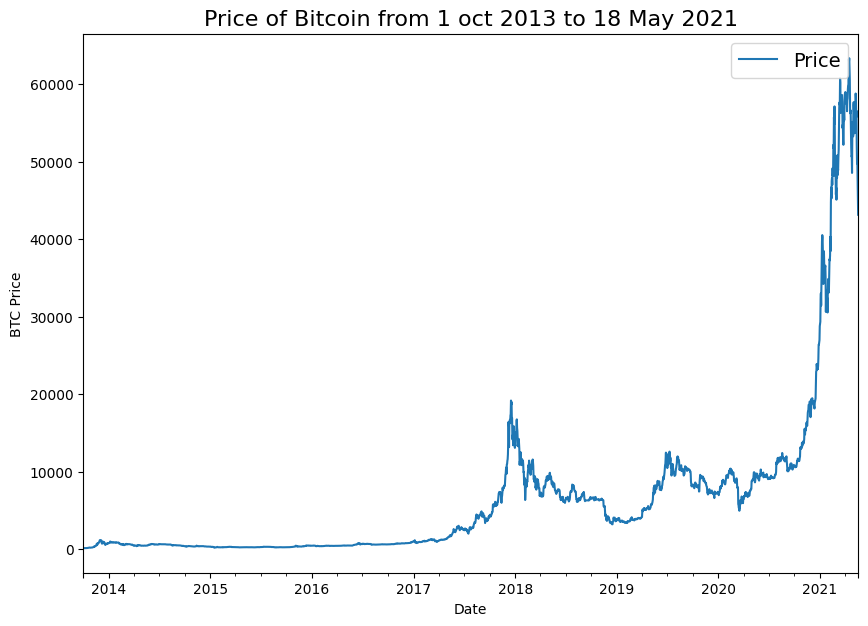

In [ ]:
import matplotlib.pyplot as plt
bitcoin_prices.plot(figsize=(10,7))
plt.ylabel("BTC Price")
plt.title("Price of Bitcoin from 1 oct 2013 to 18 May 2021", fontsize=16)
plt.legend(fontsize=14);

### Importing time series data with Python's CSV module

If your time series data comes in CSV form you don't necessarily have to use pandas.

You can use Python's [in-built `csv` module](https://docs.python.org/3/library/csv.html). And if you're working with dates, you might also want to use Python's [`datetime`](https://docs.python.org/3/library/datetime.html).

Let's see how we can replicate the plot we created before except this time using Python's `csv` and `datetime` modules.

> 📖 **Resource:** For a great guide on using Python's `csv` module, check out Real Python's tutorial on [Reading and Writing CSV files in Python](https://realpython.com/python-csv/).

In [ ]:
# Importing and formatting historical Bitcoin data with Python
import csv
from datetime import datetime

timesteps = []
btc_price = []
with open("BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv", "r") as f:
  csv_reader = csv.reader(f, delimiter=",") # read in the target CSV
  next(csv_reader) # skip first line (this gets rid of the column titles)
  for line in csv_reader:
    timesteps.append(datetime.strptime(line[1], "%Y-%m-%d")) # get the dates as dates (not strings), strptime = string parse time
    btc_price.append(float(line[2])) # get the closing price as float

# View first 10 of each
timesteps[:10], btc_price[:10]

([datetime.datetime(2013, 10, 1, 0, 0),
  datetime.datetime(2013, 10, 2, 0, 0),
  datetime.datetime(2013, 10, 3, 0, 0),
  datetime.datetime(2013, 10, 4, 0, 0),
  datetime.datetime(2013, 10, 5, 0, 0),
  datetime.datetime(2013, 10, 6, 0, 0),
  datetime.datetime(2013, 10, 7, 0, 0),
  datetime.datetime(2013, 10, 8, 0, 0),
  datetime.datetime(2013, 10, 9, 0, 0),
  datetime.datetime(2013, 10, 10, 0, 0)],
 [123.65499,
  125.455,
  108.58483,
  118.67466,
  121.33866,
  120.65533,
  121.795,
  123.033,
  124.049,
  125.96116])

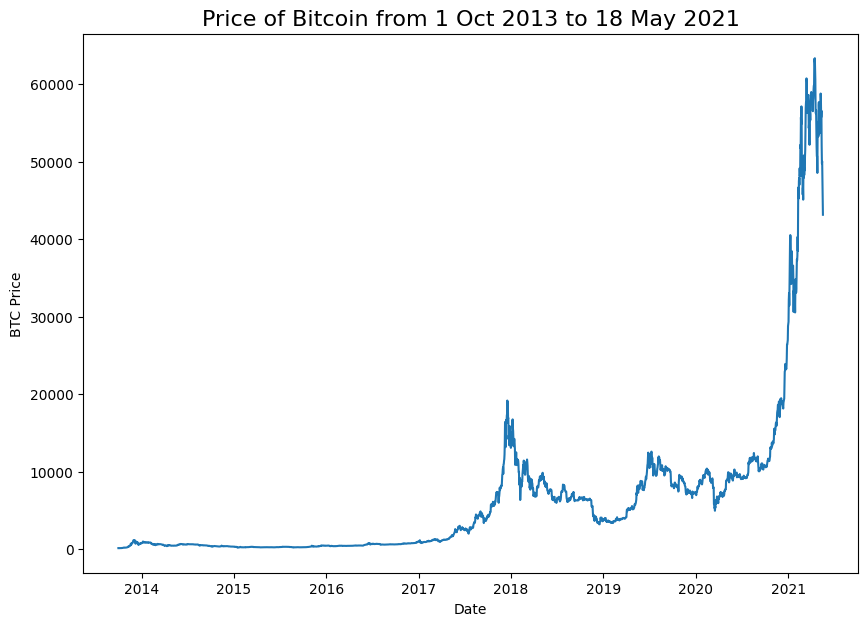

In [ ]:
# Plot from CSV
import matplotlib.pyplot as plt
import numpy as np
plt.figure(figsize=(10, 7))
plt.plot(timesteps, btc_price)
plt.title("Price of Bitcoin from 1 Oct 2013 to 18 May 2021", fontsize=16)
plt.xlabel("Date")
plt.ylabel("BTC Price");

Ho ho! Would you look at that! Just like the pandas plot. And because we formatted the `timesteps` to be `datetime` objects, `matplotlib` displays a fantastic looking date axis.

## Format Data Part 1: Creating Train and Test Sets for Time Series Data

What’s the next step?

If you guessed preparing our data for the model, you’re spot on.

### What’s the most important first step in preparing any machine learning dataset?

- Scaling?
  - No...
- Removing outliers?
  - No...
- How about creating train and test splits?
  - Yes!

Typically, you might use a function like Scikit-Learn’s [`train_test_split()`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) to create train and test splits. However, as we’ll soon discover, this approach isn’t ideal for time series data.

### What kind of data do we have?

Before creating splits, it’s essential to understand the type of data we're working with.

In time series problems, your data can be either **univariate** or **multivariate**.

- **Univariate** time series data involves a single variable, such as using the price of Bitcoin to predict future prices of Bitcoin.
- **Multivariate** time series data involves multiple variables, such as predicting electricity demand using factors like the day of the week, time of year, and the number of houses in a region.
  
Can you guess which one our data falls under?


### Create train & test sets for time series (the wrong way)

ok, we've figured out we're dealing with a univariate time series, so we only have to make a split on one variable (for multivariate time series, you will have to split multiple variables).

How about we first see the *wrong way* for splitting time series data?

Let's turn our DataFrame index and column into NumPy arrays.

In [ ]:
# Get bitcoin date array
timesteps = bitcoin_prices.index.to_numpy()
prices = bitcoin_prices['Price'].to_numpy()

timesteps[:10], prices[:10]

(array(['2013-10-01T00:00:00.000000000', '2013-10-02T00:00:00.000000000',
        '2013-10-03T00:00:00.000000000', '2013-10-04T00:00:00.000000000',
        '2013-10-05T00:00:00.000000000', '2013-10-06T00:00:00.000000000',
        '2013-10-07T00:00:00.000000000', '2013-10-08T00:00:00.000000000',
        '2013-10-09T00:00:00.000000000', '2013-10-10T00:00:00.000000000'],
       dtype='datetime64[ns]'),
 array([123.65499, 125.455  , 108.58483, 118.67466, 121.33866, 120.65533,
        121.795  , 123.033  , 124.049  , 125.96116]))

In [ ]:
# wrong way of splitting train and test sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(timesteps,
                                                  prices,
                                                  test_size=0.2,
                                                  random_state=42)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((2229,), (558,), (2229,), (558,))

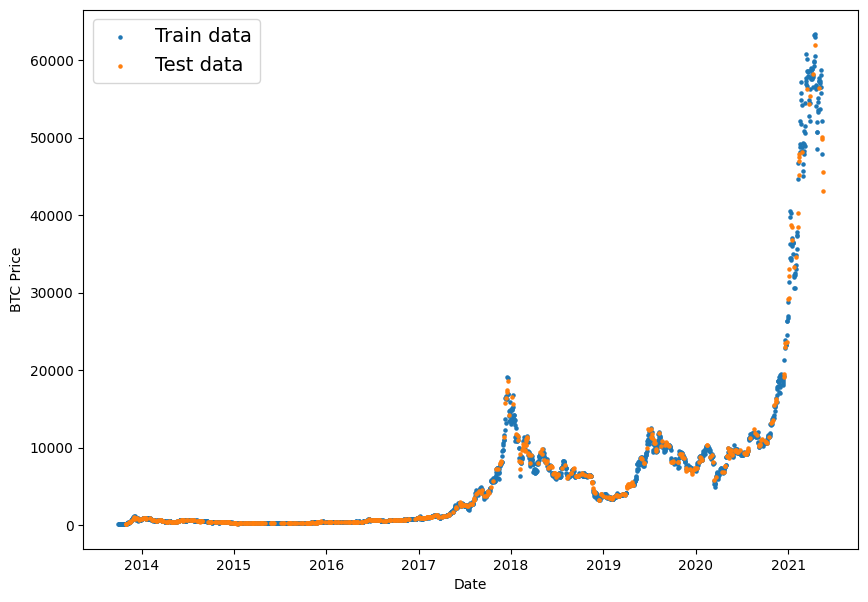

In [ ]:
# Let's plot wrong train and test splits
plt.figure(figsize=(10, 7))
plt.scatter(X_train, y_train, s=5, label="Train data")
plt.scatter(X_test, y_test, s=5, label="Test data")
plt.xlabel("Date")
plt.ylabel("BTC Price")
plt.legend(fontsize=14)
plt.show();

### Create train & test sets for time series (the right way)

Of course, there's no way we can actually access data from the future.

But we can engineer our test set to be in the future with respect to the training set.

To do this, we can create an abitrary point in time to split our data.

Everything before the point in time can be considered the training set and everything after the point in time can be considered the test set.

In [ ]:
# Create train and test splits the right way for time series data
split_size = int(0.8*len(prices))

# Create train data splits (everything before the split)
X_train, y_train = timesteps[:split_size], prices[:split_size]

# Create test data splits (everything after the split)
X_test, y_test = timesteps[split_size:], prices[split_size:]

len(X_train), len(X_test), len(y_train), len(y_test)

(2229, 558, 2229, 558)

### Create a plotting function

Rather than retyping `matplotlib` commands to continuously plot data, let's make a plotting function we can reuse later.

In [ ]:
def plot_time_series(timesteps, values, format='.', start=0, end=None, label=None):
  """
  Plots a timesteps (a series of points in time) against values (a series of values across timesteps).

  Parameters
  ---------
  timesteps : array of timesteps
  values : array of values across time
  format : style of plot, default "."
  start : where to start the plot (setting a value will index from start of timesteps & values)
  end : where to end the plot (setting a value will index from end of timesteps & values)
  label : label to show on plot of values
  """
  #plot the series
  plt.plot(timesteps[start:end], values[start:end], format, label=label)
  plt.xlabel("Time")
  plt.ylabel("BTC Price")
  if label:
    plt.legend(fontsize=14) #Make label bigger
  plt.grid(True)

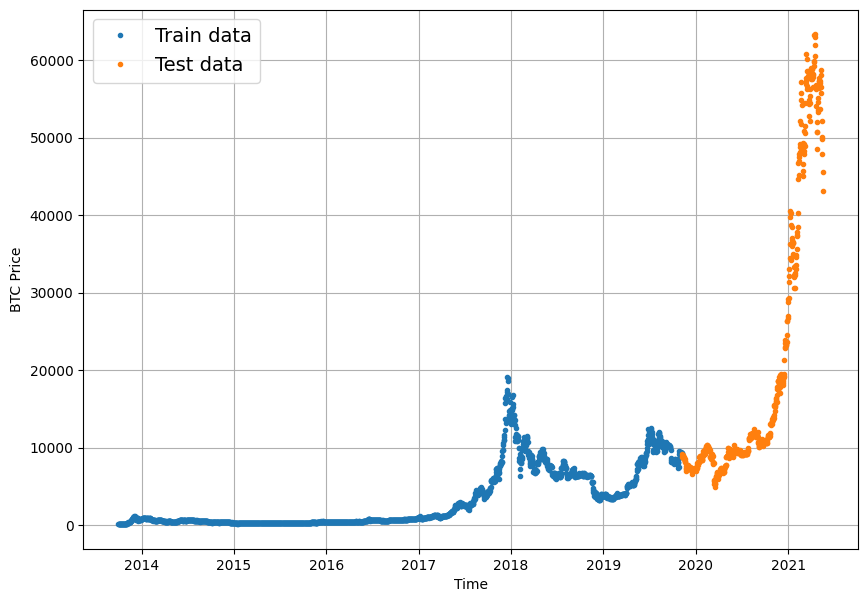

In [ ]:
# Try out our plotting function
plt.figure(figsize=(10, 7))
plot_time_series(X_train, y_train, label='Train data')
plot_time_series(X_test, y_test, label="Test data")

## Modeling Experiments

We can create a wide variety of models for our problem, as long as the data inputs and outputs are properly formatted.

However, just because we *can* build *almost any* model, it doesn't mean it will perform well or be suitable for production use. We’ll explore this as we build and evaluate different models.

### Two Key Terms: **Horizon** and **Window**

Before diving into our modeling experiments, it's important to understand two key concepts:

- **Horizon**: The number of time steps to predict into the future.
- **Window**: The number of past time steps used to predict the horizon.

For example, if we want to predict tomorrow's Bitcoin price (1-day horizon) using the last week's worth of prices (7-day window), the horizon would be 1, and the window would be 7.

### Modeling Experiments Overview

Now, let’s take a look at the modeling experiments we’ll run:

| Model Number | Model Type | Horizon size | Window size | Extra data |
| ------------- | ------------- | ------------- | ------------- | ------------- |
| 0 | Naïve model (baseline) | NA | NA | NA |
| 1 | Dense model | 1 | 7 | NA |
| 2 | Same as 1 | 1 | 30 | NA |
| 3 | Same as 1 | 7 | 30 | NA |
| 4 | Conv1D | 1 | 7 | NA |
| 5 | LSTM | 1 | 7 | NA |
| 6 | Same as 1 (with multivariate data) | 1 | 7 | Block reward size |
| 7 | [N-BEATs Algorithm](https://arxiv.org/pdf/1905.10437.pdf) | 1 | 7 | NA |
| 8 | Ensemble (multiple models optimized on different loss functions) | 1 | 7 | NA |
| 9 | Future prediction model | 1 | 7 | NA|
| 10 | Same as 1 (with turkey 🦃 data introduced) | 1 | 7 | NA |

> 🔑 **Note:** As you can see, we can build various models for the data we’re working with. However, this doesn’t guarantee their performance. Deep learning is a powerful tool, but it doesn’t always work. Always start with a simple model, then add complexity as needed.


## Model 0: Naïve Forecast (Baseline)

Let's begin with a baseline model.

One of the most common baselines for time series forecasting is the naïve model (also known as the [naïve forecast](https://otexts.com/fpp3/simple-methods.html#na%C3%AFve-method)). The best part? It requires no training.

The naïve model simply predicts that the next timestep's value will be the same as the previous timestep's value. The formula for this is:

$$\hat{y}_{t} = y_{t-1}$$

In plain English:
> The prediction at timestep `t` (y-hat) is the same as the value at timestep `t-1` (the previous timestep).

Sounds simple, right?

But in an open system, like a stock or crypto market, it’s often surprisingly difficult to beat the naïve forecast with more complex models.

> 🔑 **Note:** In this notebook, an **open system** refers to a system where inputs and outputs can freely flow, such as a market (stock or crypto). On the other hand, a **closed system** is where inputs and outputs are contained within the system (like a poker game with your friends, where you know the buy-in and the potential winnings). Time series forecasting in **open systems** is typically challenging.


In [ ]:
# creata a naive forecast
naive_forecast = y_test[:-1] # Naive forecast equals value excluding the last value
naive_forecast[:10], naive_forecast[-10:]

(array([9226.48582088, 8794.35864452, 8798.04205463, 9081.18687849,
        8711.53433917, 8760.89271814, 8749.52059102, 8656.97092235,
        8500.64355816, 8469.2608989 ]),
 array([57107.12067189, 58788.20967893, 58102.19142623, 55715.54665129,
        56573.5554719 , 52147.82118698, 49764.1320816 , 50032.69313676,
        47885.62525472, 45604.61575361]))

In [ ]:
y_test[-10:]

array([58788.20967893, 58102.19142623, 55715.54665129, 56573.5554719 ,
       52147.82118698, 49764.1320816 , 50032.69313676, 47885.62525472,
       45604.61575361, 43144.47129086])

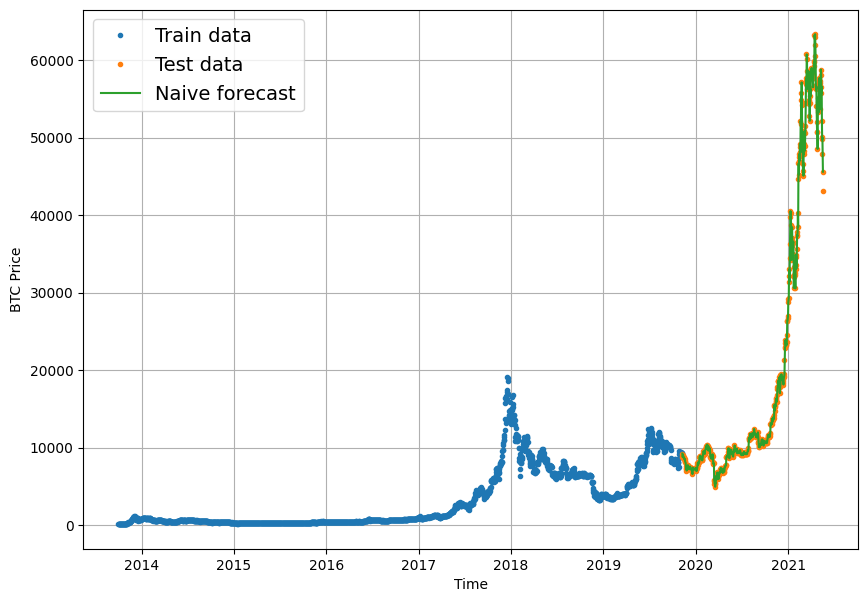

In [ ]:
# Plot naive forecast
plt.figure(figsize=(10, 7))
plot_time_series(X_train, y_train, label="Train data")
plot_time_series(X_test, y_test, label='Test data')
plot_time_series(X_test[1:], naive_forecast, format='-', label='Naive forecast')

The naive forecast looks like it's following the data well.

Let's zoom in to take a better look.

We can do so by creating an offset value and passing it to the `start` parameter of our `plot_time_series()` function.

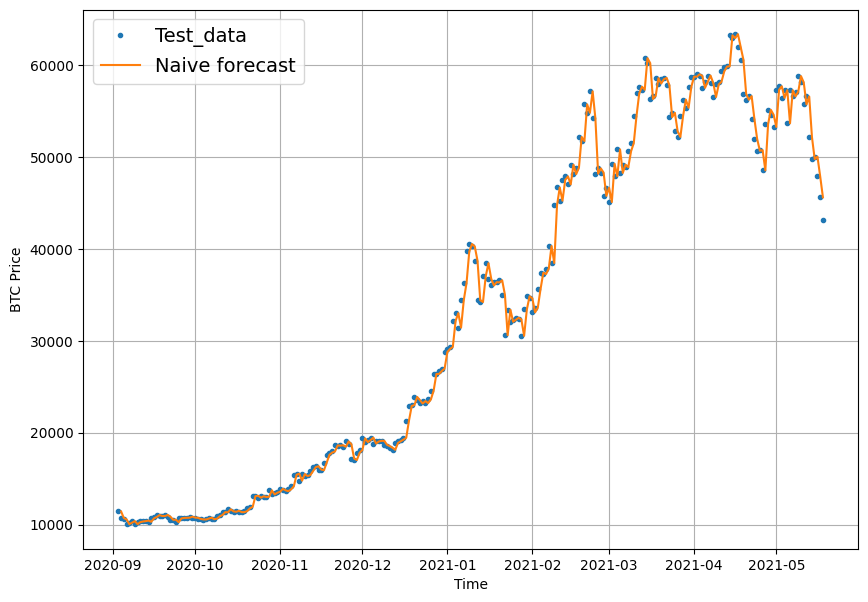

In [ ]:
plt.figure(figsize=(10,7))
offset=300
plot_time_series(X_test, y_test, start=offset, label="Test_data")
plot_time_series(X_test[1:], naive_forecast, format='-', start=offset, label='Naive forecast')

## Evaluating a Time Series Model

When forecasting time series data, like predicting Bitcoin's price, we're often dealing with a regression problem.

This means we can use regression evaluation metrics to measure how well our models perform.

The key question we'll focus on is: **How do our model's predictions (`y_pred`) compare to the actual values (`y_true` or *ground truth values*)?**

> 📖 **Resource:** We'll be using several metrics to evaluate the accuracy of our time series forecasts. Many of these metrics are detailed in [Forecasting: Principles and Practice chapter 5.8](https://otexts.com/fpp3/accuracy.html), which provides a deeper understanding of the concepts we'll cover.

For the metrics below, **lower values indicate better performance** (e.g., an MAE of 0 is better than an MAE of 100).

### Scale-Dependent Errors

These metrics compare time series values and forecasts that are on the same scale.

For example, comparing Bitcoin historical prices in USD to forecast values in USD.

| Metric | Details | Code |
| ----- | ----- | ----- |
| **MAE** (Mean Absolute Error) | Easy to interpret (a forecast is X amount different from the actual value). Minimizing MAE leads to forecasts of the median. | [`tf.keras.metrics.mean_absolute_error()`](https://www.tensorflow.org/api_docs/python/tf/keras/metrics/MeanAbsoluteError) |
| **RMSE** (Root Mean Square Error) | Minimizing RMSE leads to forecasts of the mean. | `tf.sqrt(`[`tf.keras.metrics.mean_squared_error()`](https://www.tensorflow.org/api_docs/python/tf/keras/metrics/RootMeanSquaredError)`)`|

### Percentage Errors

Percentage errors have no units, allowing comparisons across different datasets.

| **Metric** | **Details** | **Code** |
| ----- | ----- | ----- |
| **MAPE** (Mean Absolute Percentage Error) | Most commonly used percentage error. May not work if `y=0`. | [`tf.keras.metrics.mean_absolute_percentage_error()`](https://www.tensorflow.org/api_docs/python/tf/keras/losses/MAPE) |
| **sMAPE** (Symmetric Mean Absolute Percentage Error) | Not recommended by [Forecasting: Principles and Practice](https://otexts.com/fpp3/accuracy.html#percentage-errors), though used in forecasting competitions. | Custom implementation |

### Scaled Errors

Scaled errors are an alternative to percentage errors for comparing forecast performance across different time series.

| **Metric** | **Details** | **Code** |
| ----- | ----- | ----- |
| **MASE** (Mean Absolute Scaled Error) | MASE equals one for the naïve forecast. A forecast performing better than the naïve should have a MASE of less than 1. | See sktime's [`mase_loss()`](https://github.com/alan-turing-institute/sktime/blob/ee7a06843a44f4aaec7582d847e36073a9ab0566/sktime/performance_metrics/forecasting/_functions.py#L16) |

> 🤔 **Question:** With so many metrics, which one should I focus on? It depends on your problem, but MAE is often a good place to start due to its simplicity and ease of explanation.

Since we'll be evaluating many models, let’s write a function to calculate these evaluation metrics for our forecasts.

First, we’ll need TensorFlow.


In [ ]:
import tensorflow as tf

In [ ]:
# MASE implemented courtesy of sktime - https://github.com/alan-turing-institute/sktime/blob/ee7a06843a44f4aaec7582d847e36073a9ab0566/sktime/performance_metrics/forecasting/_functions.py#L16
def mean_absolute_scaled_error(y_true, y_pred):
  """
  Implement MASE (assuming no seasonality of data)
  """
  mae = tf.reduce_mean(tf.abs(y_true - y_pred))

  # Find MAE of naive forecast (no seasonality)
  mae_naive_no_season = tf.reduce_mean(tf.abs(y_true[1:] - y_pred[:-1])) # our seasonality is 1 day (hence the shifting of 1 day)

  return mae/ mae_naive_no_season

In [ ]:
def evaluate_preds(y_true, y_pred):
    # Make sure float32 for metric calculations
    y_true = tf.cast(y_true, dtype=tf.float32)
    y_pred = tf.cast(y_pred, dtype=tf.float32)

    # Calculate various metrics
    mae = tf.keras.metrics.MeanAbsoluteError()(y_true, y_pred)
    mse = tf.keras.metrics.MeanSquaredError()(y_true, y_pred)
    rmse = tf.sqrt(mse)
    mape = tf.keras.metrics.MeanAbsolutePercentageError()(y_true, y_pred)
    mase = mean_absolute_scaled_error(y_true, y_pred)

    return {
        "MAE": mae.numpy(),
        "MSE": mse.numpy(),
        "RMSE": rmse.numpy(),
        "MAPE": mape.numpy(),
        "MASE": mase.numpy()
    }

In [ ]:
naive_results = evaluate_preds(y_test[1:],
                               naive_forecast)
naive_results

2024-09-20 13:40:28.057216: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-09-20 13:40:28.093675: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-09-20 13:40:28.093719: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-09-20 13:40:28.097339: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-09-20 13:40:28.097412: I external/local_xla/xla/stream_executor

{'MAE': 567.9802,
 'MSE': 1147547.0,
 'RMSE': 1071.2362,
 'MAPE': 2.516525,
 'MASE': 0.69212395}

In [ ]:
# Find average price of Bitcoin in test dataset
tf.reduce_mean(y_test).numpy()

20056.632963737222

## Other kinds of time series forecasting models which can be used for baselines and actual forecasts

Since we've got a naïve forecast baseline to work with, it's time we start building models to try and beat it.

And because this course is focused on TensorFlow and deep learning, we're going to be using TensorFlow to build deep learning models to try and improve on our naïve forecasting results.

That being said, there are many other kinds of models you may want to look into for building baselines/performing forecasts.

Some of them may even beat our best performing models in this notebook, however, I'll leave trying them out for extra-curriculum.

| **Model/Library Name** | **Resource** |
| ----- | ----- |
| Moving average | https://machinelearningmastery.com/moving-average-smoothing-for-time-series-forecasting-python/ |
| ARIMA (Autoregression Integrated Moving Average) | https://machinelearningmastery.com/arima-for-time-series-forecasting-with-python/ |
| sktime (Scikit-Learn for time series) | https://github.com/alan-turing-institute/sktime |
| TensorFlow Decision Forests (random forest, gradient boosting trees) | https://www.tensorflow.org/decision_forests |
| Facebook Kats (purpose-built forecasting and time series analysis library by Facebook) | https://github.com/facebookresearch/Kats |
| LinkedIn Greykite (flexible, intuitive and fast forecasts) | https://github.com/linkedin/greykite |

## Format Data Part 2: Windowing Dataset

We’re almost ready to start building our models, but there's one more step (really two) to complete.

We need to **window** our time series data.

### Why Window the Data?

Windowing transforms a time series dataset into a **supervised learning problem**.

In other words, we use past data windows to predict future values.

For instance, if we want to use a window of one week (`window=7`) to predict the next single value (`horizon=1`) for a univariate time series, it might look like this:

```
Window for one week (univariate time series)

[0, 1, 2, 3, 4, 5, 6] -> [7]
[1, 2, 3, 4, 5, 6, 7] -> [8]
[2, 3, 4, 5, 6, 7, 8] -> [9]
```


For predicting Bitcoin prices, it would look like this:

```
Window for one week with the target of predicting the next day (Bitcoin prices)

[123.654, 125.455, 108.584, 118.674, 121.338, 120.655, 121.795] -> [123.033]
[125.455, 108.584, 118.674, 121.338, 120.655, 121.795, 123.033] -> [124.049]
[108.584, 118.674, 121.338, 120.655, 121.795, 123.033, 124.049] -> [125.961]
```

Let's build some functions which take in a univariate time series and turn it into windows and horizons of specified sizes.

We'll start with the default horizon size of 1 and a window size of 7 (these aren't necessarily the best values to use, I've just picked them).


In [ ]:
HORIZON = 1
WINDOW_SIZE = 7

In [ ]:
def get_labelled_windows(x, horizon=1):
  """
  Creates labels for windowed dataset

  E.g. if horizon=1 (Default)
  Input: [1,2,3,4,5,6] -> output: ([1,2,3,4,5], [6])
  """
  return x[:, :-horizon], x[:, -horizon:]

In [ ]:
# Test out the window labelling function
test_window, test_label = get_labelled_windows(tf.expand_dims(tf.range(8)+1, axis=0), horizon=HORIZON)
print(f"Window: {tf.squeeze(test_window).numpy()} -> Label: {tf.squeeze(test_label).numpy()}")

Window: [1 2 3 4 5 6 7] -> Label: 8


### Creating Windows for the Entire Time Series

To efficiently create windows for the entire time series, we could use Python for loops. However, for large datasets, this approach can be slow.

To speed up the process, we’ll use [NumPy's array indexing](https://numpy.org/doc/stable/reference/arrays.indexing.html).

The following steps will help us:

1. We’ll use NumPy to create overlapping slices (windows) of our time series data.
2. These windows will be used to train our models.
3. We’ll apply the `get_labelled_windows()` function (created earlier) to convert these window slices into labeled windows with a specified horizon.

> 📖 **Resource:** The function created below is adapted from Syafiq Kamarul Azman's article [*Fast and Robust Sliding Window Vectorization with NumPy*](https://towardsdatascience.com/fast-and-robust-sliding-window-vectorization-with-numpy-3ad950ed62f5).


In [ ]:
import numpy as np
# create function to view NumPy arrays as windows
def make_windows(x, window_size=7, horizon=1):
  """
  Turns a 1D array into a 2D array of sequential windows of window size
  """
  # 1. create a window of specific window_size (add the horizon on the end for later labelling)
  window_step = np.expand_dims(np.arange(window_size+horizon), axis=0)

  # 2. Create a 2D array of multiple window steps (minus 1 to account for 0 indexing)
  window_indexes = window_step + np.expand_dims(np.arange(len(x)-(window_size+horizon-1)), axis=0).T # create 2D array of windows of size window_size

  # 3. Index on the target array (time series) with 2D array of multiple window steps
  windowed_array = x[window_indexes]

  # 4. Get the labelled windows
  windows, labels = get_labelled_windows(windowed_array, horizon=horizon)

  return windows, labels


To understand above func refer to this:

window_step = `[[0, 1, 2, 3, 4, 5, 6, 7]]`

window_indexes will result in:
`[[0], [1], [2],....] + [[0, 1, 2, 3, 4, 5, 6, 7]]`

This results in:
```
[[0]+[0, 1, 2, 3, 4, 5, 6, 7],
[1]+[0, 1, 2, 3, 4, 5, 6, 7],
[2]+[0, 1, 2, 3, 4, 5, 6, 7],
....] = [[0, 1, 2, 3, 4, 5, 6, 7], [1, 2, 3, 4, 5, 6, 7, 8], [2, 3, 4, 5, 6, 7, 8, 9],....]
```

In [ ]:
full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

(2780, 2780)

In [ ]:
# View the first 3 windows/labels
for i in range(3):
  print(f"Window: {full_windows[i]} -> Label: {full_labels[i]}")

Window: [123.65499 125.455   108.58483 118.67466 121.33866 120.65533 121.795  ] -> Label: [123.033]
Window: [125.455   108.58483 118.67466 121.33866 120.65533 121.795   123.033  ] -> Label: [124.049]
Window: [108.58483 118.67466 121.33866 120.65533 121.795   123.033   124.049  ] -> Label: [125.96116]


In [ ]:
# View the last 3 windows/labels
for i in range(3):
  print(f"Window: {full_windows[i-3]} -> Label: {full_labels[i-3]}")

Window: [58788.20967893 58102.19142623 55715.54665129 56573.5554719
 52147.82118698 49764.1320816  50032.69313676] -> Label: [47885.62525472]
Window: [58102.19142623 55715.54665129 56573.5554719  52147.82118698
 49764.1320816  50032.69313676 47885.62525472] -> Label: [45604.61575361]
Window: [55715.54665129 56573.5554719  52147.82118698 49764.1320816
 50032.69313676 47885.62525472 45604.61575361] -> Label: [43144.47129086]


In [ ]:
# Make the train/test splits
def make_train_test_splits(windows, labels, test_split=0.2):
  """
  Splits matching pairs of windows and labels into train and test splits.
  """
  split_size = int(len(windows) * (1-test_split))
  train_windows = windows[:split_size]
  train_labels = labels[:split_size]
  test_windows = windows[split_size:]
  test_labels = labels[split_size:]
  return train_windows, test_windows, train_labels, test_labels

In [ ]:
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(full_windows, full_labels)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2224, 556, 2224, 556)

In [ ]:
train_windows[:5], train_labels[:5]

(array([[123.65499, 125.455  , 108.58483, 118.67466, 121.33866, 120.65533,
         121.795  ],
        [125.455  , 108.58483, 118.67466, 121.33866, 120.65533, 121.795  ,
         123.033  ],
        [108.58483, 118.67466, 121.33866, 120.65533, 121.795  , 123.033  ,
         124.049  ],
        [118.67466, 121.33866, 120.65533, 121.795  , 123.033  , 124.049  ,
         125.96116],
        [121.33866, 120.65533, 121.795  , 123.033  , 124.049  , 125.96116,
         125.27966]]),
 array([[123.033  ],
        [124.049  ],
        [125.96116],
        [125.27966],
        [125.9275 ]]))

In [ ]:
# Check to see if same (accounting for horizon and window size)
np.array_equal(np.squeeze(train_labels[:-HORIZON-1]), y_train[WINDOW_SIZE:])

True

## Create a Model Checkpoint

We're almost ready to build our models—just one more crucial step!

Given that our model's performance may vary across different experiments, it's important to ensure that we're comparing them fairly. This means we need to compare the best performance of each model against the best performance of other models.

To make this comparison consistent, we'll save each model's best version during training. This approach allows us to run multiple experiments while keeping track of the best-performing models by saving them under different names.

Next, we'll write a small function to create a `ModelCheckpoint` callback, which saves a model to a specified filename.


In [ ]:
import os
# create a function to implement a ModelCheckpoint callback with a specific filename
def create_model_checkpoint(model_name, save_path="model_experiments"):
  return tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(save_path, model_name+".keras"),
                                            verbose=1,
                                            monitor='val_loss',
                                            save_best_only= True)

## Model 1: Dense model (window = 7, horizon = 1)

Finally!

Time to build one of our models.

If you think we've been through a fair bit of preprocessing before getting here, you're right.

Often, preparing data for a model is one of the largest parts of any machine learning project.

And once you've got a good model in place, you'll probably notice far more improvements from manipulating the data (e.g. collecting more, improving the quality) than manipulating the model.

We're going to start by keeping it simple, model_1 will have:

A single dense layer with 128 hidden units and ReLU (rectified linear unit) activation
An output layer with linear activation (or no activation)
Adam optimizer and MAE loss function
Batch size of 128
100 epochs
Why these values?

I picked them out of experimentation.

A batch size of 32 works pretty well too and we could always train for less epochs but since the model runs so fast (you'll see in a second, it's because the number of samples we have isn't massive) we might as well train for more.

> 🔑 **Note:** As always, many of the values for machine learning problems are experimental. A reminder that the values you can set yourself in a machine learning algorithm (the hidden units, the batch size, horizon size, window size) are called [**hyperparameters**](https://en.wikipedia.org/wiki/Hyperparameter_(machine_learning). And experimenting to find the best values for hyperparameters is called **hyperparameter tuning**. Where as parameters learned by a model itself (patterns in the data, formally called weights & biases) are referred to as **parameters**.

Let's import TensorFlow and build our first deep learning model for time series.

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers

#set random seed for as reproducible results as possible
tf.random.set_seed(42)

# construct model
model_1 = tf.keras.Sequential([
    layers.Dense(128, activation='relu'),
    layers.Dense(HORIZON, activation='linear')
], name='model_1_dense')

# Compile model
model_1.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["mae"]) # we don't necessarily need this when the loss function is already MAE

# fit the model
model_1.fit(x=train_windows,
            y=train_labels,
            epochs=100,
            verbose=1,
            batch_size=128,
            validation_data = (test_windows, test_labels),
            callbacks= [create_model_checkpoint(model_name=model_1.name)])

Epoch 1/100


2024-09-20 13:40:29.917238: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f77da7722c0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-09-20 13:40:29.917289: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 4070 Laptop GPU, Compute Capability 8.9
2024-09-20 13:40:29.925105: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-09-20 13:40:29.943704: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8907
I0000 00:00:1726857630.001190 1089682 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


18/18 [==============================] - ETA: 0s - loss: 1302.9817 - mae: 1302.9817 
Epoch 1: val_loss improved from inf to 3166.06689, saving model to model_experiments/model_1_dense.keras
18/18 [==============================] - 1s 12ms/step - loss: 1302.9817 - mae: 1302.9817 - val_loss: 3166.0669 - val_mae: 3166.0667
Epoch 2/100
17/18 [===========================>..] - ETA: 0s - loss: 333.6412 - mae: 333.6412
Epoch 2: val_loss improved from 3166.06689 to 1058.36047, saving model to model_experiments/model_1_dense.keras
18/18 [==============================] - 0s 6ms/step - loss: 329.3643 - mae: 329.3643 - val_loss: 1058.3605 - val_mae: 1058.3605
Epoch 3/100
17/18 [===========================>..] - ETA: 0s - loss: 198.2496 - mae: 198.2496
Epoch 3: val_loss improved from 1058.36047 to 1010.60193, saving model to model_experiments/model_1_dense.keras
18/18 [==============================] - 0s 6ms/step - loss: 196.4008 - mae: 196.4008 - val_loss: 1010.6019 - val_mae: 1010.6019
Epoch 4/

In [ ]:
# Evaluate model on test data
model_1.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 2ms/step - loss: 642.8337 - mae: 642.8337


[642.8336791992188, 642.8336791992188]

In [ ]:
model_1 = tf.keras.models.load_model("model_experiments/model_1_dense.keras")
model_1.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 2ms/step - loss: 561.8497 - mae: 561.8497


[561.8497314453125, 561.8497314453125]

## Making Forecasts with a Model (on the Test Dataset)

We've trained our model and evaluated it on the test data. But since our project is called BitPredict 💰📈, how can we use our model to make predictions?

Since we'll be running multiple modeling experiments, let's create a function that:
1. Takes in a trained model (like `model_1`).
2. Accepts some input data (similar to what the model was trained on).
3. Passes the input data through the model's `predict()` method.
4. Returns the predictions.


In [ ]:
def make_preds(model, input_data):
  """
  Uses model to make predictions on input_data.

  Parameters
  ----------
  model: trained model
  input_data: windowed input data (same kind of data model was trained on)

  Returns model predictions on input_data.
  """
  forecast = model.predict(input_data)
  return tf.squeeze(forecast) # return 1D array of predictions

In [ ]:
# Make predictions using model_1 on the test dataset and view the results
model_1_preds = make_preds(model_1, test_windows)
len(model_1_preds), model_1_preds[:10]

18/18 [==============================] - 0s 1ms/step


(556,
 <tf.Tensor: shape=(10,), dtype=float32, numpy=
 array([8833.359, 8757.156, 8996.206, 8771.995, 8736.336, 8699.845,
        8660.241, 8526.939, 8425.245, 8508.802], dtype=float32)>)

In [ ]:
#Evaluate preds
model_1_results = evaluate_preds(y_true = tf.squeeze(test_labels),
                                 y_pred = model_1_preds)

model_1_results

{'MAE': 561.84973,
 'MSE': 1150861.1,
 'RMSE': 1072.782,
 'MAPE': 2.5373905,
 'MASE': 0.6800274}

In [ ]:
naive_results

{'MAE': 567.9802,
 'MSE': 1147547.0,
 'RMSE': 1071.2362,
 'MAPE': 2.516525,
 'MASE': 0.69212395}

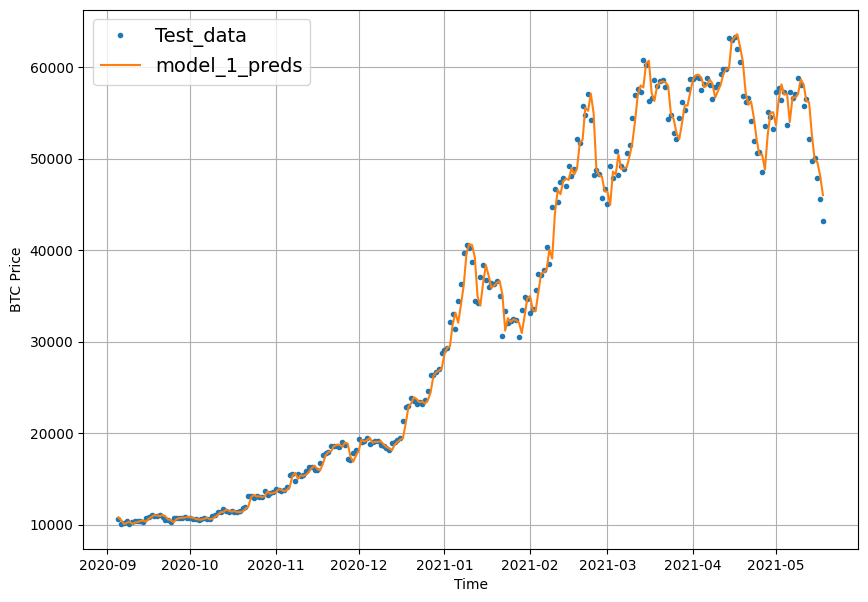

In [ ]:
offset = 300
plt.figure(figsize=(10, 7))
# Account for the test_window offset and index into test_labels to ensure correct plotting
plot_time_series(timesteps=X_test[-len(test_windows):], values=test_labels[:,0], start=offset, label='Test_data')
plot_time_series(timesteps=X_test[-len(test_windows):], values=model_1_preds, start=offset, format='-', label='model_1_preds')

## Model 2: Dense (window = 30, horizon = 1)

A naïve model is currently beating our handcrafted deep learning model.

We can't let this happen.

Let's continue our modelling experiments.

We'll keep the previous model architecture but use a window size of 30.

In other words, we'll use the previous 30 days of Bitcoin prices to try and predict the next day price.

> 🔑 **Note:** Recall from before, the window size (how many timesteps to use to fuel a forecast) and the horizon (how many timesteps to predict into the future) are **hyperparameters**. This means you can tune them to try and find values will result in better performance.

We'll start our second modelling experiment by preparing datasets using the functions we created earlier.

In [ ]:
HORIZON = 1
WINDOW_SIZE = 30

In [ ]:
# Make windowed data with appropriate horizon and window sizes
full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

(2757, 2757)

In [ ]:
# Make train and testing windows
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(windows=full_windows, labels=full_labels)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2205, 552, 2205, 552)

In [ ]:
tf.random.set_seed(42)

# Create model (same model as model 1 but data input will be different)
model_2 = tf.keras.Sequential([
  layers.Dense(128, activation="relu"),
  layers.Dense(HORIZON)
], name='model_2_dense')

model_2.compile(loss='mae',
                optimizer = tf.keras.optimizers.Adam())

model_2.fit(train_windows,
            train_labels,
            epochs=100,
            batch_size=128,
            verbose=0,
            validation_data = (test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_2.name)])


Epoch 1: val_loss improved from inf to 1143.21082, saving model to model_experiments/model_2_dense.keras

Epoch 2: val_loss improved from 1143.21082 to 1063.13672, saving model to model_experiments/model_2_dense.keras

Epoch 3: val_loss improved from 1063.13672 to 1028.23486, saving model to model_experiments/model_2_dense.keras

Epoch 4: val_loss did not improve from 1028.23486

Epoch 5: val_loss improved from 1028.23486 to 897.82477, saving model to model_experiments/model_2_dense.keras

Epoch 6: val_loss did not improve from 897.82477

Epoch 7: val_loss improved from 897.82477 to 846.85034, saving model to model_experiments/model_2_dense.keras

Epoch 8: val_loss did not improve from 846.85034

Epoch 9: val_loss improved from 846.85034 to 832.10870, saving model to model_experiments/model_2_dense.keras

Epoch 10: val_loss improved from 832.10870 to 820.51746, saving model to model_experiments/model_2_dense.keras

Epoch 11: val_loss did not improve from 820.51746

Epoch 12: val_loss 

In [ ]:
# Evaluate model 2 preds
model_2.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 2ms/step - loss: 627.2184


627.2183837890625

In [ ]:
# Load in best performing model
model_2 = tf.keras.models.load_model("model_experiments/model_2_dense.keras")
model_2.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 2ms/step - loss: 627.2184


627.2183837890625

In [ ]:
# Get forecast predictions
model_2_preds = make_preds(model_2,
                           input_data=test_windows)

18/18 [==============================] - 0s 1ms/step


In [ ]:
# Evaluate results for model 2 predictions
model_2_results = evaluate_preds(y_true=tf.squeeze(test_labels), # remove 1 dimension of test labels
                                 y_pred=model_2_preds)
model_2_results

{'MAE': 627.2184,
 'MSE': 1323390.4,
 'RMSE': 1150.3871,
 'MAPE': 2.8267379,
 'MASE': 0.72009516}

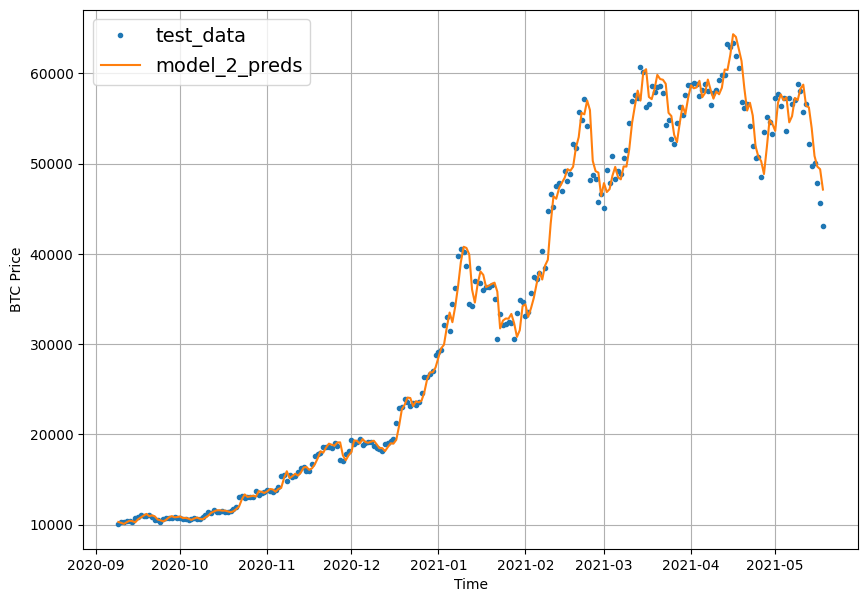

In [ ]:
offset = 300
plt.figure(figsize=(10, 7))
# Account for the test_window offset
plot_time_series(timesteps=X_test[-len(test_windows):], values=test_labels[:, 0], start=offset, label="test_data")
plot_time_series(timesteps=X_test[-len(test_windows):], values=model_2_preds, start=offset, format="-", label="model_2_preds")

## Model 3: Dense (window = 30, horizon = 7)

Let's try and predict 7 days ahead given the previous 30 days.

First, we'll update the `HORIZON` and `WINDOW_SIZE` variables and create windowed data.


In [ ]:
HORIZON= 7
WINDOW_SIZE = 30

full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

(2751, 2751)

In [ ]:
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(windows=full_windows, labels = full_labels, test_split=0.2)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2200, 551, 2200, 551)

In [ ]:
tf.random.set_seed(42)

# create model (same as model_1 except with diff data input size)
model_3 = tf.keras.Sequential([
    layers.Dense(128, activation='relu'),
    layers.Dense(HORIZON)
], name="model_3_dense")

model_3.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

model_3.fit(train_windows,
            train_labels,
            batch_size=128,
            epochs=100,
            verbose=0,
            validation_data = (test_windows, test_labels),
            callbacks = [create_model_checkpoint(model_name=model_3.name)])


Epoch 1: val_loss improved from inf to 5616.50537, saving model to model_experiments/model_3_dense.keras

Epoch 2: val_loss improved from 5616.50537 to 2450.66284, saving model to model_experiments/model_3_dense.keras

Epoch 3: val_loss improved from 2450.66284 to 2122.38574, saving model to model_experiments/model_3_dense.keras

Epoch 4: val_loss improved from 2122.38574 to 1923.87268, saving model to model_experiments/model_3_dense.keras

Epoch 5: val_loss did not improve from 1923.87268

Epoch 6: val_loss improved from 1923.87268 to 1808.66638, saving model to model_experiments/model_3_dense.keras

Epoch 7: val_loss improved from 1808.66638 to 1638.52466, saving model to model_experiments/model_3_dense.keras

Epoch 8: val_loss did not improve from 1638.52466

Epoch 9: val_loss did not improve from 1638.52466

Epoch 10: val_loss improved from 1638.52466 to 1606.89099, saving model to model_experiments/model_3_dense.keras

Epoch 11: val_loss improved from 1606.89099 to 1566.70300, sa

In [ ]:
# How did our model with a larger window size and horizon go?
model_3.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 2ms/step - loss: 1438.2609


1438.2608642578125

In [ ]:
model_3 = tf.keras.models.load_model("model_experiments/model_3_dense.keras")
model_3.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 2ms/step - loss: 1229.5696


1229.569580078125

In [ ]:
model_3_preds = make_preds(model_3, test_windows)
model_3_preds[:5]

18/18 [==============================] - 0s 1ms/step


<tf.Tensor: shape=(5, 7), dtype=float32, numpy=
array([[9393.44  , 9416.155 , 9377.194 , 9427.    , 9611.984 , 9785.32  ,
        9389.995 ],
       [9131.522 , 9039.88  , 9054.021 , 9218.063 , 9248.842 , 9581.863 ,
        9245.959 ],
       [8869.372 , 8937.396 , 8849.366 , 9086.837 , 9142.077 , 9242.716 ,
        9211.786 ],
       [8904.899 , 9100.741 , 9071.032 , 9443.251 , 9186.345 , 9047.634 ,
        9405.249 ],
       [8657.6045, 8889.927 , 9047.494 , 9356.026 , 8905.65  , 8848.6   ,
        9161.175 ]], dtype=float32)>

In [ ]:
model_3_results = evaluate_preds(tf.squeeze(test_labels),
                                 model_3_preds)

model_3_results

{'MAE': 1229.5695,
 'MSE': 5432461.0,
 'RMSE': 2330.764,
 'MAPE': 5.5479784,
 'MASE': 0.8829758}

Make our evaluation function work for larger horizons

if you notice the outputs for `model_3_results` are multi-dimensional.

This is because the predictions are getting evaluated across the `HORIZON` timesteps (7 predictions at a time).

To fix this, adjust our `evaluate_preds()` function to work with multiple shapes of data.

In [ ]:
def evaluate_preds(y_true, y_pred):
  # Make sure float32 (for metric calculations)
  y_true = tf.cast(y_true, dtype=tf.float32)
  y_pred = tf.cast(y_pred, dtype=tf.float32)

  # Calculate various metrics
  mae = tf.keras.metrics.mean_absolute_error(y_true, y_pred)
  mse = tf.keras.metrics.mean_squared_error(y_true, y_pred)
  rmse = tf.sqrt(mse)
  mape = tf.keras.metrics.mean_absolute_percentage_error(y_true, y_pred)
  mase = mean_absolute_scaled_error(y_true, y_pred)

  # Account for different sized metrics (for longer horizons, reduce to single number)
  if mae.ndim > 0: # if mae isn't already a scalar, reduce it to one by aggregating tensors to mean
    mae = tf.reduce_mean(mae)
    mse = tf.reduce_mean(mse)
    rmse = tf.reduce_mean(rmse)
    mape = tf.reduce_mean(mape)
    mase = tf.reduce_mean(mase)

  return {"mae": mae.numpy(),
          "mse": mse.numpy(),
          "rmse": rmse.numpy(),
          "mape": mape.numpy(),
          "mase": mase.numpy()}

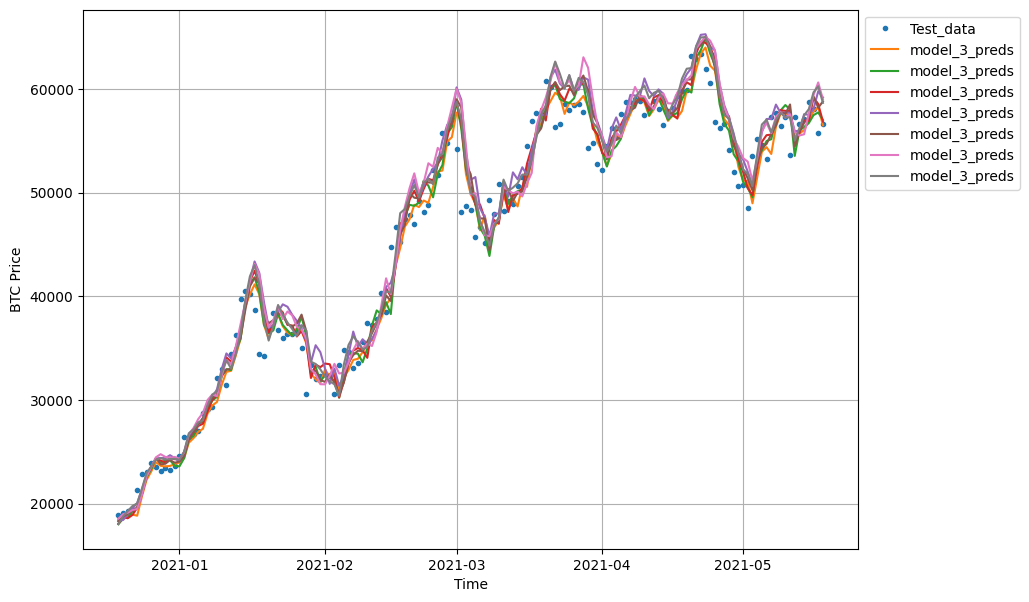

In [ ]:
offset = 400
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_test[-len(test_windows):], values=test_labels[:,0], start=offset, label='Test_data')
plot_time_series(timesteps=X_test[-len(test_windows):], values=model_3_preds, start=offset, format='-', label="model_3_preds")
plt.legend(bbox_to_anchor=(1, 1))

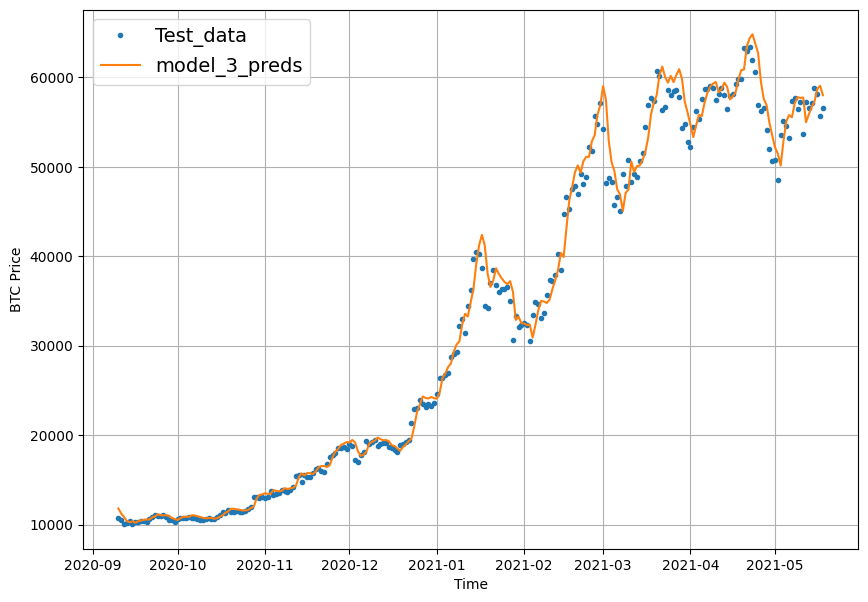

In [ ]:
offset = 300
plt.figure(figsize=(10, 7))
# Plot model_3_preds by aggregating them (note: this condenses information so the preds will look fruther ahead than the test data)
plot_time_series(timesteps=X_test[-len(test_windows):],
                 values=test_labels[:, 0],
                 start=offset,
                 label="Test_data")
plot_time_series(timesteps=X_test[-len(test_windows):],
                 values=tf.reduce_mean(model_3_preds, axis=1),
                 format="-",
                 start=offset,
                 label="model_3_preds")

## Which of our models is performing best so far?

So far, we've trained 3 models which use the same architecture but use different data inputs.

Let's compare them with the naïve model to see which model is performing the best so far.

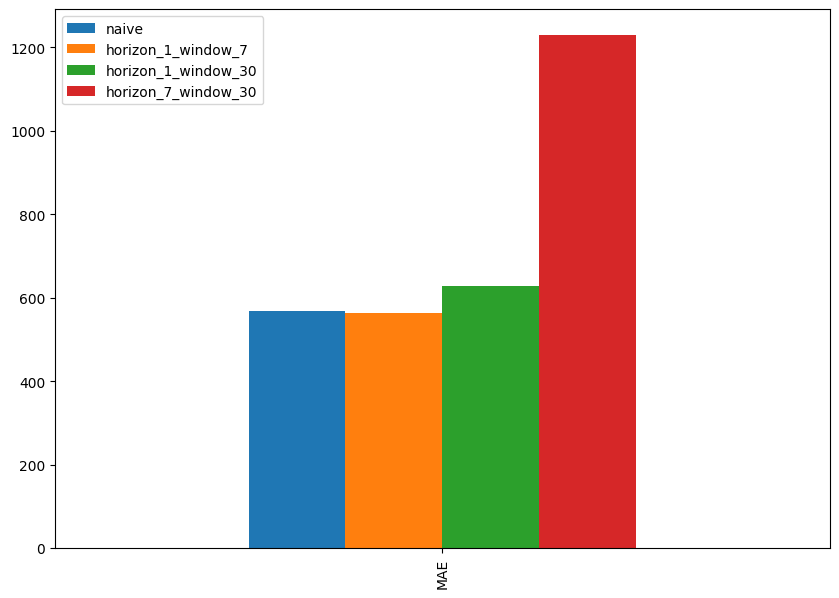

In [ ]:
pd.DataFrame({"naive": naive_results["MAE"],
              "horizon_1_window_7": model_1_results["MAE"],
              "horizon_1_window_30": model_2_results["MAE"],
              "horizon_7_window_30": model_3_results["MAE"]}, index=["MAE"]).plot(figsize=(10, 7), kind="bar");

## Model 4: Conv1D

Let's move on to the next modeling experiment!

This time, we'll be using a Conv1D model. As we saw in the sequence modeling notebook, Conv1D models are well-suited for seq2seq (sequence to sequence) problems.

In our case, the input sequence consists of the previous 7 days of Bitcoin price data, and the output is the next day's price (in seq2seq terms, this is known as a "many-to-one" problem).


In [ ]:
HORIZON = 1 # predict next day
WINDOW_SIZE = 7 # use previous week worth of data

In [ ]:
# Create windowed dataset
full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

(2780, 2780)

In [ ]:
# Create train/test splits
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(full_windows, full_labels)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2224, 556, 2224, 556)

Data windowed!

Now, since we're going to be using [Conv1D layers](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv1D), we need to make sure our input shapes are correct.

The Conv1D layer in TensorFlow takes an input of: `(batch_size, timesteps, input_dim)`.

In our case, the `batch_size` (by default this is 32 but we can change it) is handled for us but the other values will be:
* `timesteps = WINDOW_SIZE` - the `timesteps` is also often referred to as `features`, our features are the previous `WINDOW_SIZE` values of Bitcoin
* `input_dim = HORIZON` - our model views `WINDOW_SIZE` (one week) worth of data at a time to predict `HORIZON` (one day)

Right now, our data has the `timesteps` dimension ready but we'll have to adjust it to have the `input_dim` dimension.

In [ ]:
# Check data sample shapes
train_windows[0].shape

(7,)

In [ ]:
# Before we pass our data to the Conv1D layer, we have to reshape it in order to make sure it works
x = tf.constant(train_windows[0])
expand_dims_layer = layers.Lambda(lambda x: tf.expand_dims(x, axis=1))
print(f"Original shape: {x.shape}")
print(f"Expanded shape: {expand_dims_layer(x).shape}")
print(f"Original values with expanded shape:\n {expand_dims_layer(x)}")

Original shape: (7,)
Expanded shape: (7, 1)
Original values with expanded shape:
 [[123.65499]
 [125.455  ]
 [108.58483]
 [118.67466]
 [121.33866]
 [120.65533]
 [121.795  ]]


Looking good!

Now we've got a Lambda layer, let's build, compile, fit and evaluate a Conv1D model on our data.

> 🔑 **Note:** If you run the model below without the Lambda layer, you'll get an input shape error (one of the most common errors when building neural networks).

In [ ]:
tf.random.set_seed(42)

# Create model
model_4 = tf.keras.Sequential([
    layers.Lambda(lambda x: tf.expand_dims(x, axis=1)),
    layers.Conv1D(filters=128, kernel_size=5, padding='causal', activation='relu'),
    layers.Dense(HORIZON)
], name='model_4_conv1D')

# compile the model
model_4.compile(loss='mae',
                optimizer=tf.keras.optimizers.Adam())

# fit model
model_4.fit(train_windows,
            train_labels,
            batch_size=128,
            epochs=100,
            verbose=0,
            validation_data=(test_windows, test_labels),
            callbacks = [create_model_checkpoint(model_name=model_4.name)])

2024-09-20 13:40:56.006482: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory



Epoch 1: val_loss improved from inf to 5169.40283, saving model to model_experiments/model_4_conv1D.keras

Epoch 2: val_loss improved from 5169.40283 to 1011.15515, saving model to model_experiments/model_4_conv1D.keras

Epoch 3: val_loss improved from 1011.15515 to 995.92871, saving model to model_experiments/model_4_conv1D.keras

Epoch 4: val_loss improved from 995.92871 to 987.54071, saving model to model_experiments/model_4_conv1D.keras

Epoch 5: val_loss improved from 987.54071 to 972.27148, saving model to model_experiments/model_4_conv1D.keras

Epoch 6: val_loss improved from 972.27148 to 969.62488, saving model to model_experiments/model_4_conv1D.keras

Epoch 7: val_loss improved from 969.62488 to 946.60895, saving model to model_experiments/model_4_conv1D.keras

Epoch 8: val_loss improved from 946.60895 to 942.93530, saving model to model_experiments/model_4_conv1D.keras

Epoch 9: val_loss did not improve from 942.93530

Epoch 10: val_loss improved from 942.93530 to 922.65900

In [ ]:
model_4.summary()

Model: "model_4_conv1D"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda_1 (Lambda)           (None, 1, 7)              0         
                                                                 
 conv1d (Conv1D)             (None, 1, 128)            4608      
                                                                 
 dense_6 (Dense)             (None, 1, 1)              129       
                                                                 
Total params: 4737 (18.50 KB)
Trainable params: 4737 (18.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
# Load in best performing Conv1D model and evaluate it on the test data
import keras

model_4 = tf.keras.models.load_model("model_experiments/model_4_conv1D.keras", safe_mode=False)
model_4.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 2ms/step - loss: 574.7847


574.7847290039062

In [ ]:
# Make predictions
model_4_preds = make_preds(model_4, test_windows)
model_4_preds[:10]

18/18 [==============================] - 0s 2ms/step


<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([8896.543, 8767.426, 8994.203, 8797.382, 8713.249, 8745.782,
       8681.016, 8526.814, 8455.799, 8513.139], dtype=float32)>

In [ ]:
# Evaluate predictions
model_4_results = evaluate_preds(y_true=tf.squeeze(test_labels),
                                 y_pred=model_4_preds)
model_4_results

{'mae': 574.7848,
 'mse': 1200913.4,
 'rmse': 1095.8619,
 'mape': 2.5791004,
 'mase': 0.6847514}

## Model 5: RNN (LSTM)

As you might expect, we can also use a recurrent neural network (RNN) to model our sequential time series data.

> 📖 **Resource:** For more information on the different types of RNNs you can use for sequence problems, check out the [Recurrent Neural Networks section of notebook 08](https://dev.mrdbourke.com/tensorflow-deep-learning/08_introduction_to_nlp_in_tensorflow/#recurrent-neural-networks-rnns).

In this experiment, we'll reuse the same data we used for the Conv1D model but will apply an [LSTM-cell](https://www.tensorflow.org/api_docs/python/tf/keras/layers/LSTM) powered RNN to model our Bitcoin data.

One of the key steps for the LSTM model will be getting our data into the right shape.

The [`tf.keras.layers.LSTM()`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/LSTM) layer requires input tensors with dimensions `[batch, timesteps, feature]`.

While the `batch` dimension is handled automatically, our data currently only includes the `feature` dimension (`WINDOW_SIZE`).

To address this, similar to how we did with the `Conv1D` model, we'll use a `tf.keras.layers.Lambda()` layer to reshape our input tensors appropriately for the LSTM layer.


In [ ]:
tf.random.set_seed(42)

# let's build an LSTM model with the functional API
inputs = layers.Input(shape=(WINDOW_SIZE))
x = layers.Lambda(lambda x: tf.expand_dims(x, axis=1))(inputs)
# print(x.shape)
# x = layers.LSTM(128, activation="relu", return_sequences=True)(x) # this layer will error if the inputs are not the right shape
x = layers.LSTM(124, activation='relu')(x)
# print(x.shape)
# Add another optional dense layer (you could add more of these to see if they improve model performance)
# x = layers.Dense(32, activation="relu")(x)
output = layers.Dense(HORIZON)(x)
model_5 = tf.keras.Model(inputs=inputs, outputs = output, name='model_5_lstm')

#compile the model
model_5.compile(loss='mae',
                optimizer = tf.keras.optimizers.Adam())

# fit the model
model_5.fit(train_windows,
            train_labels,
            epochs=100,
            verbose=0,
            batch_size=128,
            validation_data = (test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_5.name)])


Epoch 1: val_loss improved from inf to 8017.45703, saving model to model_experiments/model_5_lstm.keras

Epoch 2: val_loss improved from 8017.45703 to 1827.08594, saving model to model_experiments/model_5_lstm.keras

Epoch 3: val_loss improved from 1827.08594 to 1342.21667, saving model to model_experiments/model_5_lstm.keras

Epoch 4: val_loss improved from 1342.21667 to 1017.55554, saving model to model_experiments/model_5_lstm.keras

Epoch 5: val_loss did not improve from 1017.55554

Epoch 6: val_loss did not improve from 1017.55554

Epoch 7: val_loss did not improve from 1017.55554

Epoch 8: val_loss did not improve from 1017.55554

Epoch 9: val_loss improved from 1017.55554 to 1014.93707, saving model to model_experiments/model_5_lstm.keras

Epoch 10: val_loss improved from 1014.93707 to 996.93738, saving model to model_experiments/model_5_lstm.keras

Epoch 11: val_loss improved from 996.93738 to 979.39380, saving model to model_experiments/model_5_lstm.keras

Epoch 12: val_loss 

In [ ]:
# Load in best version of model 5 and evaluate on the test data
model_5 = tf.keras.models.load_model("model_experiments/model_5_lstm.keras", safe_mode=False)
model_5.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 2ms/step - loss: 599.3598


599.3598022460938

In [ ]:
# Make predictions with our LSTM model
model_5_preds = make_preds(model_5, test_windows)
model_5_preds[:10]

18/18 [==============================] - 0s 1ms/step


<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([8937.252, 8792.574, 8937.926, 8767.125, 8720.641, 8719.975,
       8684.806, 8521.526, 8456.304, 8490.791], dtype=float32)>

In [ ]:
# Evaluate model 5 preds
model_5_results = evaluate_preds(y_true=tf.squeeze(test_labels),
                                 y_pred=model_5_preds)
model_5_results

{'mae': 599.3598,
 'mse': 1274343.5,
 'rmse': 1128.8683,
 'mape': 2.7021267,
 'mase': 0.69811845}

 it seems even with an LSTM-powered RNN we weren't able to beat our naïve models results.

Perhaps adding another variable will help?

> 🔑 **Note:** I'm putting this here again as a reminder that because neural networks are such powerful algorithms, they can be used for almost any problem, however, that doesn't mean they'll achieve performant or usable results. You're probably starting to clue onto this now.


## Create a Multivariate Time Series

So far, all of our models have struggled to outperform the naïve forecast.

Additionally, all of these models have been trained on a single variable (univariate time series): the historical price of Bitcoin.

If predicting Bitcoin's future price based solely on its historical price hasn't worked well, maybe providing our model with more information could help.

"More information" is a broad term, as we could feed almost anything into our model and it would still try to find patterns.

For example, we could use the historical price of Bitcoin along with whether anyone named [Daniel Bourke tweeted](https://twitter.com/mrdbourke) that day to predict Bitcoin's future price. But would this help?

Probably not.

It would be more useful to pass something related to Bitcoin into our model (though in an open system like a market, almost everything could be considered related).

The additional data you use depends on the time series you're working with, but for our case, we could explore whether adding the [Bitcoin block reward size](https://www.investopedia.com/terms/b/block-reward.asp) improves our model's predictive power.

### What is the Bitcoin block reward size?

The Bitcoin block reward size refers to the number of Bitcoins someone receives for mining a Bitcoin block.

At its inception, the Bitcoin block reward was 50 BTC. However, every four years or so, the Bitcoin block reward is halved.

For example, the block reward dropped from 50 BTC (starting in January 2009) to 25 BTC on November 28, 2012.

Let’s encode this information into our time series data and see if it improves our model's performance.

> 🔑 **Note:** By adding an extra feature like the Bitcoin block reward size, we transition from a **univariate** dataset (just the historical price of Bitcoin) to a **multivariate** dataset (including both the price of Bitcoin and the block reward size).


In [ ]:
# Let's make a multivariate time series
bitcoin_prices.head()

,Price
Date,
2013-10-01,123.65499
2013-10-02,125.45500
2013-10-03,108.58483
2013-10-04,118.67466
2013-10-05,121.33866


Alright, time to add another feature column, the block reward size.

First, we'll need to create variables for the different block reward sizes as well as the dates they came into play.

The following block rewards and dates were sourced from [cmcmarkets.com](https://www.cmcmarkets.com/en/learn-cryptocurrencies/bitcoin-halving).

| Block Reward | Start Date |
| ----- | ----- |
| 50 | 3 January 2009 (2009-01-03) |
| 25 | 28 November 2012 |
| 12.5 | 9 July 2016 |
| 6.25 | 11 May 2020 |
| 3.125 | TBA (expected 2024) |
| 1.5625 | TBA (expected 2028) |

> 🔑 **Note:** Since our Bitcoin historical data starts from 01 October 2013, none of the timesteps in our multivariate time series will have a block reward of 50.

In [ ]:
# Block reward values
block_reward_1 = 50 # 3 January 2009 (2009-01-03) - this block reward isn't in our dataset (it starts from 01 October 2013)
block_reward_2 = 25 # 28 November 2012
block_reward_3 = 12.5 # 9 July 2016
block_reward_4 = 6.25 # 11 May 2020

# Block reward dates (datetime form of the above date stamps)
block_reward_2_datetime = np.datetime64("2012-11-28")
block_reward_3_datetime = np.datetime64("2016-07-09")
block_reward_4_datetime = np.datetime64("2020-05-11")

In [ ]:
# Get date indexes for when to add in different block dates
block_reward_2_days = (block_reward_3_datetime - bitcoin_prices.index[0]).days
block_reward_3_days = (block_reward_4_datetime - bitcoin_prices.index[0]).days
block_reward_2_days, block_reward_3_days

(1012, 2414)

In [ ]:
# Add block_reward column
bitcoin_prices_block = bitcoin_prices.copy()
bitcoin_prices_block["block_reward"] = None

# Set values of block_reward column (it's the last column hence -1 indexing on iloc)
bitcoin_prices_block.iloc[:block_reward_2_days, -1] = block_reward_2
bitcoin_prices_block.iloc[block_reward_2_days:block_reward_3_days, -1] = block_reward_3
bitcoin_prices_block.iloc[block_reward_3_days:, -1] = block_reward_4
bitcoin_prices_block.head()

,Price,block_reward
Date,,
2013-10-01,123.65499,25
2013-10-02,125.45500,25
2013-10-03,108.58483,25
2013-10-04,118.67466,25
2013-10-05,121.33866,25


<Axes: xlabel='Date'>

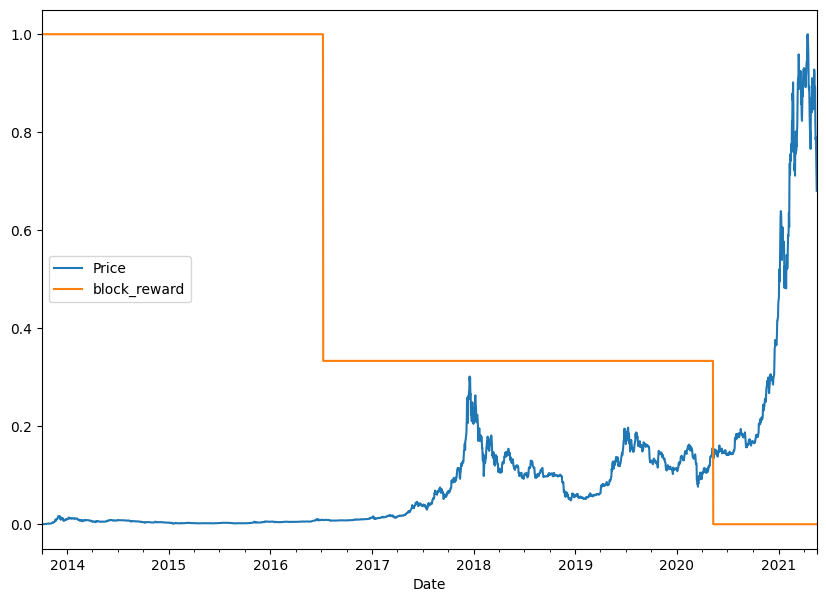

In [ ]:
# plot the blaock reward/price over time
from sklearn.preprocessing import minmax_scale
scaled_price_block_df = pd.DataFrame(minmax_scale(bitcoin_prices_block[["Price","block_reward"]]),
                                     columns = bitcoin_prices_block.columns,
                                     index = bitcoin_prices_block.index)

scaled_price_block_df.plot(figsize=(10,7))

## Creating a Windowed Dataset with Pandas

Earlier, we used custom functions to window our **univariate** time series.

However, now that we've added another variable to our dataset, those functions won't work.

No need to worry! Since our data is stored in a pandas DataFrame, we can use the [`pandas.DataFrame.shift()`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.shift.html) method to create a windowed **multivariate** time series.

The `shift()` method offsets an index by a specified number of periods.

Let’s see how it works.


In [ ]:
#setup dataset hyperparameters
HORIZON = 1
WINDOW_SIZE = 7

In [ ]:
# Make a copy of a Bitcoin historical data with block reward feature
bitcoin_prices_windowed = bitcoin_prices_block.copy()

# Add windowed columns
for i in range(WINDOW_SIZE):
  bitcoin_prices_windowed[f"Price+{i+1}"] = bitcoin_prices_windowed["Price"].shift(periods=i+1)
bitcoin_prices_windowed

,Price,block_reward,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,,
2013-10-01,123.654990,25,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-02,125.455000,25,123.654990,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-03,108.584830,25,125.455000,123.654990,NaN,NaN,NaN,NaN,NaN
2013-10-04,118.674660,25,108.584830,125.455000,123.654990,NaN,NaN,NaN,NaN
2013-10-05,121.338660,25,118.674660,108.584830,125.455000,123.654990,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
2021-05-14,49764.132082,6.25,52147.821187,56573.555472,55715.546651,58102.191426,58788.209679,57107.120672,56583.849879
2021-05-15,50032.693137,6.25,49764.132082,52147.821187,56573.555472,55715.546651,58102.191426,58788.209679,57107.120672
2021-05-16,47885.625255,6.25,50032.693137,49764.132082,52147.821187,56573.555472,55715.546651,58102.191426,58788.209679


In [ ]:
# Let's create X & y, remove the NaN's and convert to float32 to prevent TensorFlow errors
X = bitcoin_prices_windowed.dropna().drop("Price", axis=1).astype(np.float32)
y = bitcoin_prices_windowed.dropna()["Price"].astype(np.float32)
X.head()

,block_reward,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,
2013-10-08,25.0,121.794998,120.655327,121.338661,118.674660,108.584831,125.455002,123.654991
2013-10-09,25.0,123.032997,121.794998,120.655327,121.338661,118.674660,108.584831,125.455002
2013-10-10,25.0,124.049004,123.032997,121.794998,120.655327,121.338661,118.674660,108.584831
2013-10-11,25.0,125.961159,124.049004,123.032997,121.794998,120.655327,121.338661,118.674660
2013-10-12,25.0,125.279663,125.961159,124.049004,123.032997,121.794998,120.655327,121.338661


In [ ]:
# View labels
y.head()

Date
2013-10-08    123.032997
2013-10-09    124.049004
2013-10-10    125.961159
2013-10-11    125.279663
2013-10-12    125.927498
Name: Price, dtype: float32

In [ ]:
# Make train and test sets
split_size = int(len(X) * 0.8)
X_train, y_train = X[:split_size], y[:split_size]
X_test, y_test = X[split_size:], y[split_size:]
len(X_train), len(y_train), len(X_test), len(y_test)

(2224, 2224, 556, 556)

In [ ]:
from tensorflow.keras import layers
tf.random.set_seed(42)

# Make multivariate time series model
model_6 = tf.keras.Sequential([
    layers.Dense(128, activation='relu'),
    layers.Dense(HORIZON)
], name='model_6_dense_multivariate')

model_6.compile(loss='mae',
                optimizer = tf.keras.optimizers.Adam())

# fit
model_6.fit(X_train, y_train,
            epochs=100,
            batch_size=128,
            verbose=0,
            validation_data = (X_test, y_test),
            callbacks = [create_model_checkpoint(model_name=model_6.name)])


Epoch 1: val_loss improved from inf to 2950.31226, saving model to model_experiments/model_6_dense_multivariate.keras

Epoch 2: val_loss improved from 2950.31226 to 1716.94714, saving model to model_experiments/model_6_dense_multivariate.keras

Epoch 3: val_loss improved from 1716.94714 to 1348.63904, saving model to model_experiments/model_6_dense_multivariate.keras

Epoch 4: val_loss improved from 1348.63904 to 1189.42444, saving model to model_experiments/model_6_dense_multivariate.keras

Epoch 5: val_loss improved from 1189.42444 to 1125.43628, saving model to model_experiments/model_6_dense_multivariate.keras

Epoch 6: val_loss improved from 1125.43628 to 1083.19958, saving model to model_experiments/model_6_dense_multivariate.keras

Epoch 7: val_loss did not improve from 1083.19958

Epoch 8: val_loss improved from 1083.19958 to 1026.41211, saving model to model_experiments/model_6_dense_multivariate.keras

Epoch 9: val_loss improved from 1026.41211 to 1019.44830, saving model to

In [ ]:
# Make sure best model is loaded and evaluate
model_6 = tf.keras.models.load_model("model_experiments/model_6_dense_multivariate.keras")
model_6.evaluate(X_test, y_test)

18/18 [==============================] - 0s 2ms/step - loss: 565.0594


565.0593872070312

In [ ]:
model_6_preds = tf.squeeze(model_6.predict(X_test))
model_6_preds[:10]

18/18 [==============================] - 0s 1ms/step


<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([8829.199, 8776.415, 8994.806, 8752.138, 8768.355, 8700.489,
       8646.642, 8526.015, 8439.938, 8503.369], dtype=float32)>

In [ ]:
# Evaluate results
model_6_results = evaluate_preds(y_true=y_test,
                                 y_pred = model_6_preds)
model_6_results

{'mae': 565.0594,
 'mse': 1158709.4,
 'rmse': 1076.4336,
 'mape': 2.5494115,
 'mase': 0.679583}

## Model 7: N-BEATS Algorithm

Time to take things up a notch.

So far, we've experimented with smaller models that only have a few layers. But one of the most effective ways to improve a model's performance is by increasing the number of layers.

That's exactly what the [N-BEATS (Neural Basis Expansion Analysis for Interpretable Time Series Forecasting) algorithm](https://arxiv.org/pdf/1905.10437.pdf) does.

The N-BEATS algorithm focuses on univariate time series problems and achieved state-of-the-art performance, even winning the [M4 competition](https://www.sciencedirect.com/science/article/pii/S0169207019301128) (a major forecasting competition).

For our next modeling experiment, we will replicate the **generic architecture** of the N-BEATS algorithm as described in [section 3.3 of the N-BEATS paper](https://arxiv.org/pdf/1905.10437.pdf).

We won't dive into all the details from the paper, but we'll focus on:
1. Replicating the model architecture shown in [Figure 1 of the N-BEATS paper](https://arxiv.org/pdf/1905.10437.pdf).

![Figure 1 from the N-BEATS paper, which we'll replicate](https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/10-figure-1-nbeats-paper-annotated.png)
*This shows the N-BEATS algorithm we'll replicate in TensorFlow, with window (input) and horizon (output) annotations.*

2. Using the same hyperparameters as the paper, found in [Appendix D of the N-BEATS paper](https://arxiv.org/pdf/1905.10437.pdf).

This experiment will allow us to practice:
* Creating a custom layer for the `NBeatsBlock` by subclassing [`tf.keras.layers.Layer`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Layer).
  * Custom layers are useful when TensorFlow doesn't have an existing implementation or when we need to repeat a specific layer configuration multiple times (like stacking N-BEATS blocks).
* Implementing a custom architecture using the Functional API.
* Following a research paper and applying it to our problem.

> 🔑 **Note:** The N-BEATS paper mentions that “N-BEATS is implemented and trained in TensorFlow”—and that's exactly what we'll do!


In [ ]:
# Create NBeatsBlock custom layer
class NBeatsBlock(tf.keras.layers.Layer):
  def __init__(self, # the constructor takes all the hyperparameters for the layer
               input_size: int,
               theta_size: int,
               horizon: int,
               n_neurons: int,
               n_layers: int,
               **kwargs): # the **kwargs argument takes care of all of the arguments for the parent class (input_shape, trainable, name)
    super().__init__(**kwargs)
    self.input_size = input_size
    self.theta_size = theta_size
    self.horizon = horizon
    self.n_neurons = n_neurons
    self.n_layers = n_layers

    # Block contains stack of 4 fully connected layers each has ReLU activation
    self.hidden = [tf.keras.layers.Dense(n_neurons, activation="relu") for _ in range(n_layers)]
    # Output of block is a theta layer with linear activation
    self.theta_layer = tf.keras.layers.Dense(theta_size, activation="linear", name="theta")

  def call(self, inputs): # the call method is what runs when the layer is called
    x = inputs
    for layer in self.hidden: # pass inputs through each hidden layer
      x = layer(x)
    theta = self.theta_layer(x)
    # Output the backcast and forecast from theta
    backcast, forecast = theta[:, :self.input_size], theta[:, -self.horizon:]
    return backcast, forecast

Setting up the `NBeatsBlock` custom layer involves the following:

- The class inherits from `tf.keras.layers.Layer` (this gives it all the methods associated with `tf.keras.layers.Layer`).
- The constructor (`def __init__(...)`) takes in the layer hyperparameters as well as the `**kwargs` argument.
  - The `**kwargs` argument handles hyperparameters that aren’t explicitly mentioned in the constructor, such as `input_shape`, `trainable`, and `name`.
- Inside the constructor, the block architecture layers are created:
  - The hidden layers are a stack of fully connected layers with `n_neurons` hidden units, each using ReLU activation.
  - The theta layer uses `theta_size` hidden units with a linear activation function.
- The `call()` method is executed when the layer is invoked:
  - It first passes the inputs (e.g., the historical Bitcoin data) through each of the hidden layers (a stack of fully connected layers with ReLU activation).
  - After passing through the fully connected layers, the inputs are passed through the theta layer, where the **backcast** (backward predictions, shape: `input_size`) and **forecast** (forward predictions, shape: `horizon`) are returned.

![Code mapping to image of N-BEATS basic block](https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/10-nbeats-basic-block-replication-with-tensorflow-layer-subclassing.png)
*Replicating the N-BEATS basic block using TensorFlow layer subclassing. Refer to section 3.1 of the N-BEATS paper for more details.*

Now, let’s put our block replica into action by creating a toy version of `NBeatsBlock`.

> 📖  **Resource:** Much of the time series material you're currently going through, including the N-BEATS algorithm replication, was streamed live on Twitch. To see replays of how the algorithm was replicated, check out the [*Time series research and TensorFlow course material creation playlist*](https://youtube.com/playlist?list=PL8IpyNZ21vUSCM7nRAuS-hW_E-sgwdmaI) on the Daniel Bourke arXiv YouTube channel.

In [ ]:
# Set up dummy NBeatsBlock layer to represent inputs and outputs
dummy_nbeats_block_layer = NBeatsBlock(input_size=WINDOW_SIZE,
                                       theta_size=WINDOW_SIZE+HORIZON, # backcast + forecast
                                       horizon=HORIZON,
                                       n_neurons=128,
                                       n_layers=4)

In [ ]:
dummy_inputs = tf.expand_dims(tf.range(WINDOW_SIZE) + 1, axis=0)
dummy_inputs

<tf.Tensor: shape=(1, 7), dtype=int32, numpy=array([[1, 2, 3, 4, 5, 6, 7]], dtype=int32)>

In [ ]:
# pass dummy inputs to dummy NBeatsBlock layer
backcast, forecast = dummy_nbeats_block_layer(dummy_inputs)

# These are the activation outputs of the theta layer (they'll be random due to no training of the model)
print(f"Backcast: {tf.squeeze(backcast.numpy())}")
print(f"Forecast: {tf.squeeze(forecast.numpy())}")

Backcast: [ 0.38126248  0.49761367  0.5071739  -0.07396072 -0.06829512  0.09802748
 -0.413292  ]
Forecast: -0.266499787569046


### Preparing Data for the N-BEATS Algorithm Using `tf.data`

We’ve got the basic building block for the N-BEATS architecture ready.

Before we replicate the entire N-BEATS generic architecture, let’s prepare our data.

Since we'll be working with a larger model architecture, we want to ensure that training runs as efficiently as possible. To achieve this, we'll set up our datasets using the `tf.data` API.

Additionally, because the N-BEATS algorithm focuses on univariate time series, we’ll start by creating windowed training and test datasets using Bitcoin prices (just like we've done earlier).


In [ ]:
HORIZON = 1 # how far to predict forward
WINDOW_SIZE = 7 # how far to lookback

In [ ]:
# Create NBEATS data inputs (NBEATS works with univariate time series)
bitcoin_prices.head()

,Price
Date,
2013-10-01,123.65499
2013-10-02,125.45500
2013-10-03,108.58483
2013-10-04,118.67466
2013-10-05,121.33866


In [ ]:
# Add windowed columns
bitcoin_prices_nbeats = bitcoin_prices.copy()
for i in range(WINDOW_SIZE):
  bitcoin_prices_nbeats[f"Price+{i+1}"] = bitcoin_prices_nbeats["Price"].shift(periods=i+1)
bitcoin_prices_nbeats.dropna().head()

,Price,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,
2013-10-08,123.03300,121.79500,120.65533,121.33866,118.67466,108.58483,125.45500,123.65499
2013-10-09,124.04900,123.03300,121.79500,120.65533,121.33866,118.67466,108.58483,125.45500
2013-10-10,125.96116,124.04900,123.03300,121.79500,120.65533,121.33866,118.67466,108.58483
2013-10-11,125.27966,125.96116,124.04900,123.03300,121.79500,120.65533,121.33866,118.67466
2013-10-12,125.92750,125.27966,125.96116,124.04900,123.03300,121.79500,120.65533,121.33866


In [ ]:
# Make features and labels
X = bitcoin_prices_nbeats.dropna().drop('Price', axis=1)
y = bitcoin_prices_nbeats.dropna()["Price"]

# Make train and test sets
split_size = int(len(X) * 0.8)
X_train, y_train = X[:split_size], y[:split_size]
X_test, y_test = X[split_size:], y[split_size:]
len(X_train), len(y_train), len(X_test), len(y_test)

(2224, 2224, 556, 556)

In [ ]:
# 1. Turn train and test arrays into tensor Datasets
train_features_dataset = tf.data.Dataset.from_tensor_slices(X_train)
train_labels_dataset = tf.data.Dataset.from_tensor_slices(y_train)

test_features_dataset = tf.data.Dataset.from_tensor_slices(X_test)
test_labels_dataset = tf.data.Dataset.from_tensor_slices(y_test)

# 2. Combine features & labels
train_dataset = tf.data.Dataset.zip((train_features_dataset, train_labels_dataset))
test_dataset = tf.data.Dataset.zip((test_features_dataset, test_labels_dataset))

# 3. Batch and prefetch for optimal performance
BATCH_SIZE = 1024 # taken from Appendix D in N-BEATS paper
train_dataset = train_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

train_dataset, test_dataset

(<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 7), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 7), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>)

### Setting up hyperparameters for N-BEATS algorithm

To begin, we'll create variables for each of the hyperparameters we'll be using for our N-BEATS replica.

> 📖 **Resource:** The following hyperparameters are taken from Figure 1 and Table 18/Appendix D of the [N-BEATS paper](https://arxiv.org/pdf/1905.10437.pdf).

> 🔑 **Note:** If you see variables in a machine learning example in all caps, such as "`N_EPOCHS = 100`", these variables are often hyperparameters which are used through the example. You'll usually see them instantiated towards the start of an experiment and then used throughou

In [ ]:
# Values from N-BEATS paper Figure 1 and Table 18/Appendix D
N_EPOCHS = 5000 # called "Iterations" in Table 18
N_NEURONS = 512 # called "Width" in Table 18
N_LAYERS = 4
N_STACKS = 30

INPUT_SIZE = WINDOW_SIZE * HORIZON # called "Lookback" in Table 18
THETA_SIZE = INPUT_SIZE + HORIZON

INPUT_SIZE, THETA_SIZE

(7, 8)

### Preparing for Residual Connections

Great! Our hyperparameters are set. Now, before we build the full N-BEATS model, there are two key layers to explore that play a major role in the architecture.

These layers enable the **double residual stacking** feature of N-BEATS (see section 3.2 of the [N-BEATS paper](https://arxiv.org/pdf/1905.10437.pdf)):
- [`tf.keras.layers.subtract(inputs)`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/subtract): Subtracts a list of input tensors from each other.
- [`tf.keras.layers.add(inputs)`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/add): Adds a list of input tensors together.

Let’s test them out.


In [ ]:
from tensorflow.keras import layers

# Make tensors
tensor_1 = tf.range(10) + 10
tensor_2 = tf.range(10)

# Subtract
subtracted = layers.subtract([tensor_1, tensor_2])

# Add
added = layers.add([tensor_1, tensor_2])

print(f"Input tensors: {tensor_1.numpy()} & {tensor_2.numpy()}")
print(f"Subtracted: {subtracted.numpy()}")
print(f"Added: {added.numpy()}")

Input tensors: [10 11 12 13 14 15 16 17 18 19] & [0 1 2 3 4 5 6 7 8 9]
Subtracted: [10 10 10 10 10 10 10 10 10 10]
Added: [10 12 14 16 18 20 22 24 26 28]


### Building, Compiling, and Fitting the N-BEATS Algorithm

We’ve finally got all the pieces in place to build and train the N-BEATS algorithm. Here’s the step-by-step process:

1. Set up an instance of the N-BEATS block layer using `NBeatsBlock` (this will be the initial block for the network, with additional blocks created as part of the stacks).
2. Create an input layer for the N-BEATS stack using the [Keras Functional API](https://www.tensorflow.org/guide/keras/functional).
3. Make the initial backcast and forecast predictions using the layer created in step 1.
4. Use a `for` loop to create stacks of block layers.
5. In the `for` loop from step 4, use the `NBeatsBlock` class to create blocks that return backcasts and block-level forecasts.
6. Implement double residual stacking by using subtract and add layers.
7. Assemble the model’s inputs and outputs using [`tf.keras.Model()`](https://www.tensorflow.org/api_docs/python/tf/keras/Model).
8. Compile the model with MAE loss (the N-BEATS paper mentions multiple losses, but we’ll stick with MAE for consistency with our other models) and use the Adam optimizer with default settings as per section 5.2 of the [N-BEATS paper](https://arxiv.org/pdf/1905.10437.pdf).
9. Fit the N-BEATS model for 5000 epochs, and since it's a long training process, we’ll use two callbacks:
   * [`tf.keras.callbacks.EarlyStopping()`](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping): Stops training if validation loss doesn’t improve for 200 epochs, with `restore_best_weights=True` to revert to the best model (this prevents long training periods without improvement).
   * [`tf.keras.callbacks.ReduceLROnPlateau()`](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ReduceLROnPlateau): If validation loss doesn’t improve for 100 epochs, reduces the learning rate by 10x to make smaller updates and attempt incremental improvements.

It’s quite a few steps, but you’ve got this!

Let’s do it!


In [ ]:
%%time

tf.random.set_seed(42)

# 1. Setup N-BEATS Block layer
nbeats_block_layer = NBeatsBlock(input_size=INPUT_SIZE,
                                 theta_size=THETA_SIZE,
                                 horizon=HORIZON,
                                 n_neurons=N_NEURONS,
                                 n_layers=N_LAYERS,
                                 name="InitialBlock")

# 2. Create input to stacks
stack_input = layers.Input(shape=(INPUT_SIZE), name="stack_input")

# 3. Create initial backcast and forecast input (backwards predictions are referred to as residuals in the paper)
backcast, forecast = nbeats_block_layer(stack_input)
# Add in subtraction residual link, thank you to: https://github.com/mrdbourke/tensorflow-deep-learning/discussions/174
residuals = layers.subtract([stack_input, backcast], name=f"subtract_00")

# 4. Create stacks of blocks
for i, _ in enumerate(range(N_STACKS-1)): # first stack is already creted in (3)

  # 5. Use the NBeatsBlock to calculate the backcast as well as block forecast
  backcast, block_forecast = NBeatsBlock(
      input_size=INPUT_SIZE,
      theta_size=THETA_SIZE,
      horizon=HORIZON,
      n_neurons=N_NEURONS,
      n_layers=N_LAYERS,
      name=f"NBeatsBlock_{i}"
  )(residuals) # pass it in residuals (the backcast)

  # 6. Create the double residual stacking
  residuals = layers.subtract([residuals, backcast], name=f"subtract_{i}")
  forecast = layers.add([forecast, block_forecast], name=f"add_{i}")

# 7. Put the stack model together
model_7 = tf.keras.Model(inputs=stack_input,
                         outputs=forecast,
                         name="model_7_N-BEATS")

# 8. Compile with MAE loss and Adam optimizer
model_7.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam(0.001),
                metrics=["mae", "mse"])

# 9. Fit the model with EarlyStopping and ReduceLROnPlateau callbacks
model_7.fit(train_dataset,
            epochs=N_EPOCHS,
            validation_data=test_dataset,
            verbose=0, # prevent large amounts of training outputs
            # callbacks=[create_model_checkpoint(model_name=stack_model.name)] # saving model every epoch consumes far too much time
            callbacks=[tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=200, restore_best_weights=True),
                      tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=100, verbose=1)])


Epoch 251: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 351: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
CPU times: user 1min 8s, sys: 12.7 s, total: 1min 21s
Wall time: 1min 22s


In [ ]:
# Evaluate N-BEATS model on the test dataset
model_7.evaluate(test_dataset)

1/1 [==============================] - 0s 20ms/step - loss: 575.3661 - mae: 575.3661 - mse: 1183965.7500


[575.3661499023438, 575.3661499023438, 1183965.75]

In [ ]:
# Make predictions with N-BEATS model
model_7_preds = make_preds(model_7, test_dataset)
model_7_preds[:10]

1/1 [==============================] - 1s 771ms/step


<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([8933.506, 8867.296, 9020.582, 8775.711, 8791.119, 8791.212,
       8672.925, 8559.605, 8502.221, 8529.221], dtype=float32)>

In [ ]:
# Evaluate N-BEATS model predictions
model_7_results = evaluate_preds(y_true=y_test,
                                 y_pred=model_7_preds)
model_7_results

{'mae': 575.36615,
 'mse': 1183965.8,
 'rmse': 1088.1019,
 'mape': 2.6029954,
 'mase': 0.677768}

### Plotting the N-BEATS architecture we've created

In [ ]:
# !pip install pydot

In [ ]:
# !pip install graphviz

In [ ]:
# # Plot the N-BEATS model and inspect the architecture
# from tensorflow.keras.utils import plot_model
# plot_model(model_7)

above code works in colab without any errors

In [ ]:
# This will error out unless a "get_config()" method is implemented - this could be extra curriculum
model_7.save(model_7.name)

INFO:tensorflow:Assets written to: model_7_N-BEATS/assets


INFO:tensorflow:Assets written to: model_7_N-BEATS/assets


You'll notice a warning appears telling us to fully save our model correctly we need to implement a [`get_config()`](https://www.tensorflow.org/guide/keras/save_and_serialize#how_savedmodel_handles_custom_objects) method in our custom layer class.

> 📖 **Resource:** If you would like to save and load the N-BEATS model or any other custom or subclassed layer/model configuration, you should overwrite the `get_config()` and optionally `from_config()` methods. See the [TensorFlow Custom Objects documentation](https://www.tensorflow.org/guide/keras/save_and_serialize#custom_objects) for more.

## Model 8: Creating an ensemble (stacking different models together)



### Constructing and fitting an ensemble of models (using different loss functions)

In [ ]:
def get_ensemble_models(horizon=HORIZON,
                        train_data=train_dataset,
                        test_data=test_dataset,
                        num_iter=10,
                        num_epochs=100,
                        loss_fns=["mae", "mse", "mape"]):
  """
  Returns a list of num_iter models each trained on MAE, MSE and MAPE loss.

  For example, if num_iter=10, a list of 30 trained models will be returned:
  10 * len(["mae", "mse", "mape"]).
  """
  # Make empty list for trained ensemble models
  ensemble_models = []

  # Create num_iter number of models per loss function
  for i in range(num_iter):
    # Build and fit a new model with a different loss function
    for loss_function in loss_fns:
      print(f"Optimizing model by reducing: {loss_function} for {num_epochs} epochs, model number: {i}")

      # Construct a simple model (similar to model_1)
      model = tf.keras.Sequential([
        # Initialize layers with normal (Gaussian) distribution so we can use the models for prediction
        # interval estimation later: https://www.tensorflow.org/api_docs/python/tf/keras/initializers/HeNormal
        layers.Dense(128, kernel_initializer="he_normal", activation="relu"),
        layers.Dense(128, kernel_initializer="he_normal", activation="relu"),
        layers.Dense(HORIZON)
      ])

      # Compile simple model with current loss function
      model.compile(loss=loss_function,
                    optimizer=tf.keras.optimizers.Adam(),
                    metrics=["mae", "mse"])

      # Fit model
      model.fit(train_data,
                epochs=num_epochs,
                verbose=0,
                validation_data=test_data,
                # Add callbacks to prevent training from going/stalling for too long
                callbacks=[tf.keras.callbacks.EarlyStopping(monitor="val_loss",
                                                            patience=200,
                                                            restore_best_weights=True),
                           tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",
                                                                patience=100,
                                                                verbose=1)])

      # Append fitted model to list of ensemble models
      ensemble_models.append(model)

  return ensemble_models # return list of trained models

Ensemble model creator function created!

Let's try it out by running `num_iter=5` runs for 1000 epochs. This will result in 15 total models (5 for each different loss function).

Of course, these numbers could be tweaked to create more models trained for longer.

> 🔑 **Note:** With ensembles, you'll generally find more total models means better performance. However, this comes with the tradeoff of having to train more models (longer training time) and make predictions with more models (longer prediction time).



In [ ]:
%%time
# Get list of trained ensemble models
ensemble_models = get_ensemble_models(num_iter=5,
                                      num_epochs=1000)

Optimizing model by reducing: mae for 1000 epochs, model number: 0

Epoch 109: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 532: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 632: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.
Optimizing model by reducing: mse for 1000 epochs, model number: 0

Epoch 542: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 642: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
Optimizing model by reducing: mape for 1000 epochs, model number: 0

Epoch 214: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 928: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
Optimizing model by reducing: mae for 1000 epochs, model number: 1
Optimizing model by reducing: mse for 1000 epochs, model number: 1

Epoch 552: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 652: ReduceLROnPl

Look at all of those models!

How about we now write a function to use the list of trained ensemble models to make predictions and then return a list of predictions (one set of predictions per model)?

### Making predictions with an ensemble model

In [ ]:
# Create a function which uses a list of trained models to make and return a list of predictions
def make_ensemble_preds(ensemble_models, data):
  ensemble_preds = []
  for model in ensemble_models:
    preds = model.predict(data) # make predictions with current ensemble model
    ensemble_preds.append(preds)
  return tf.constant(tf.squeeze(ensemble_preds))

In [ ]:
# Create a list of ensemble predictions
ensemble_preds = make_ensemble_preds(ensemble_models=ensemble_models,
                                     data=test_dataset)
ensemble_preds

1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - 0s 27ms/step


<tf.Tensor: shape=(15, 556), dtype=float32, numpy=
array([[ 8833.431 ,  8775.435 ,  9055.24  , ..., 49938.125 , 49339.043 ,
        46665.348 ],
       [ 8776.4795,  8750.453 ,  9076.413 , ..., 50443.87  , 49289.188 ,
        46363.555 ],
       [ 8791.822 ,  8771.106 ,  9076.023 , ..., 49824.812 , 48104.027 ,
        45564.04  ],
       ...,
       [ 8808.939 ,  8784.796 ,  9015.273 , ..., 50420.586 , 48685.13  ,
        46527.938 ],
       [ 8779.485 ,  8765.169 ,  9043.174 , ..., 49972.965 , 48156.227 ,
        45709.06  ],
       [ 8570.726 ,  8616.326 ,  8881.895 , ..., 48683.75  , 47814.61  ,
        45179.04  ]], dtype=float32)>

Now we've got a set of ensemble predictions, we can evaluate them against the ground truth values.

However, since we've trained 15 models, there's going to be 15 sets of predictions. Rather than comparing every set of predictions to the ground truth, let's take the median (you could also take the mean too but [the median is usually more robust than the mean](https://www.johndcook.com/blog/2009/03/06/student-t-distribution-mean-median/)).

In [ ]:
# Evaluate ensemble model(s) predictions
ensemble_results = evaluate_preds(y_true=y_test,
                                  y_pred=np.median(ensemble_preds, axis=0)) # take the median across all ensemble predictions
ensemble_results

{'mae': 570.96136,
 'mse': 1145005.2,
 'rmse': 1070.0492,
 'mape': 2.5818706,
 'mase': 0.69224226}

Nice! Looks like the ensemble model is the best performing model on the MAE metric so far.

### Plotting the prediction intervals (uncertainty estimates) of our ensemble


One way of getting the 95% confidence prediction intervals for a deep learning model is the bootstrap method:
1. Take the predictions from a number of randomly initialized models (we've got this thanks to our ensemble model)
2. Measure the standard deviation of the predictions
3. Multiply standard deviation by [1.96](https://en.wikipedia.org/wiki/1.96) (assuming the distribution is Gaussian, 95% of observations fall within 1.96 standard deviations of the mean, this is why we initialized our neural networks with a normal distribution)
4. To get the prediction interval upper and lower bounds, add and subtract the value obtained in (3) to the mean/median of the predictions made in (1)


In [ ]:
# Find upper and lower bounds of ensemble predictions
def get_upper_lower(preds): # 1. Take the predictions of multiple randomly initialized deep learning neural networks

  # 2. Measure the standard deviation of the predictions
  std = tf.math.reduce_std(preds, axis=0)

  # 3. Multiply the standard deviation by 1.96
  interval = 1.96 * std # https://en.wikipedia.org/wiki/1.96

  # 4. Get the prediction interval upper and lower bounds
  preds_mean = tf.reduce_mean(preds, axis=0)
  lower, upper = preds_mean - interval, preds_mean + interval
  return lower, upper

# Get the upper and lower bounds of the 95%
lower, upper = get_upper_lower(preds=ensemble_preds)

Wonderful, now we've got the upper and lower bounds for the the 95% prediction interval, let's plot them against our ensemble model's predictions.

To do so, we can use our plotting function as well as the [`matplotlib.pyplot.fill_between()`](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.fill_between.html) method to shade in the space between the upper and lower bounds.

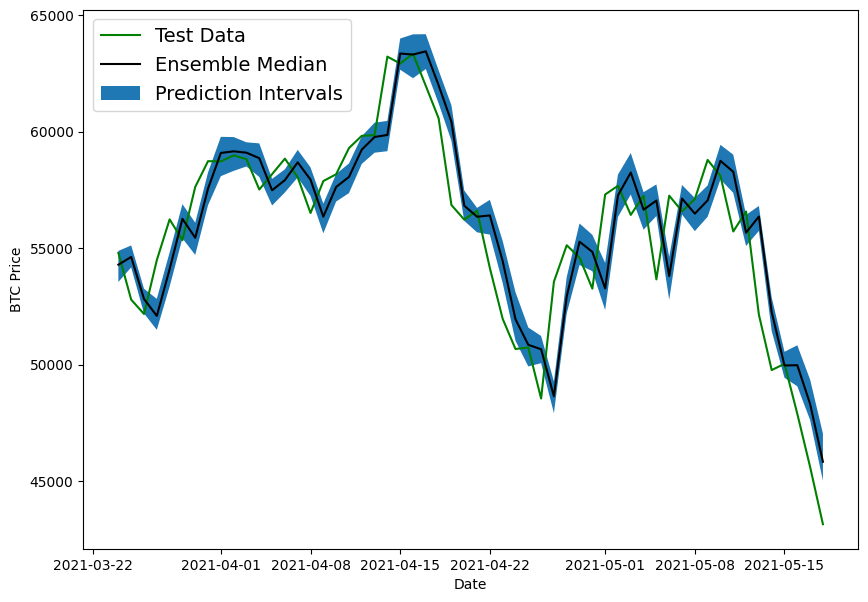

In [ ]:
# Get the median values of our ensemble preds
ensemble_median = np.median(ensemble_preds, axis=0)

# Plot the median of our ensemble preds along with the prediction intervals (where the predictions fall between)
offset=500
plt.figure(figsize=(10, 7))
plt.plot(X_test.index[offset:], y_test[offset:], "g", label="Test Data")
plt.plot(X_test.index[offset:], ensemble_median[offset:], "k-", label="Ensemble Median")
plt.xlabel("Date")
plt.ylabel("BTC Price")
plt.fill_between(X_test.index[offset:],
                 (lower)[offset:],
                 (upper)[offset:], label="Prediction Intervals")
plt.legend(loc="upper left", fontsize=14);

We've just plotted:
* The test data (the ground truth Bitcoin prices)
* The median of the ensemble predictions
* The 95% prediction intervals (assuming the data is Gaussian/normal, the model is saying that 95% of the time, predicted value should fall between this range).

## Model 9: Train a model on the full historical data to make predictions into future


In [ ]:
bitcoin_prices_windowed.head()

,Price,block_reward,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,,
2013-10-01,123.65499,25,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-02,125.45500,25,123.65499,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-03,108.58483,25,125.45500,123.65499,NaN,NaN,NaN,NaN,NaN
2013-10-04,118.67466,25,108.58483,125.45500,123.65499,NaN,NaN,NaN,NaN
2013-10-05,121.33866,25,118.67466,108.58483,125.45500,123.65499,NaN,NaN,NaN


In [ ]:
# Train model on entire data to make prediction for the next day
X_all = bitcoin_prices_windowed.drop(["Price", "block_reward"], axis=1).dropna().to_numpy() # only want prices, our future model can be a univariate model
y_all = bitcoin_prices_windowed.dropna()["Price"].to_numpy()

Windows and labels ready! Let's turn them into performance optimized TensorFlow Datasets by:
1. Turning `X_all` and `y_all` into tensor Datasets using [`tf.data.Dataset.from_tensor_slices()`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#from_tensor_slices)
2. Combining the features and labels into a Dataset tuple using [`tf.data.Dataset.zip()`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#zip)
3. Batch and prefetch the data using [`tf.data.Dataset.batch()`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#batch) and [`tf.data.Dataset.prefetch()`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#prefetch) respectively

In [ ]:
# 1. Turn X and y into tensor Datasets
features_dataset_all = tf.data.Dataset.from_tensor_slices(X_all)
labels_dataset_all = tf.data.Dataset.from_tensor_slices(y_all)

# 2. Combine features & labels
dataset_all = tf.data.Dataset.zip((features_dataset_all, labels_dataset_all))

# 3. Batch and prefetch for optimal performance
BATCH_SIZE = 1024 # taken from Appendix D in N-BEATS paper
dataset_all = dataset_all.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

dataset_all

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 7), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>

And now let's create a model similar to `model_1` except with an extra layer, we'll also fit it to the entire dataset for 100 epochs (feel free to play around with the number of epochs or callbacks here, you've got the skills to now).

In [ ]:
tf.random.set_seed(42)

# Create model (nice and simple, just to test)
model_9 = tf.keras.Sequential([
  layers.Dense(128, activation="relu"),
  layers.Dense(128, activation="relu"),
  layers.Dense(HORIZON)
])

# Compile
model_9.compile(loss=tf.keras.losses.mae,
                optimizer=tf.keras.optimizers.Adam())

# Fit model on all of the data to make future forecasts
model_9.fit(dataset_all,
            epochs=100,
            verbose=0) # don't print out anything, we've seen this all before

### Make predictions on the future

Let's predict the future and get rich!

Well... maybe not.

As you've seen so far, our machine learning models have performed quite poorly at predicting the price of Bitcoin (time series forecasting in open systems is typically a game of luck), often worse than the naive forecast.

That doesn't mean we can't use our models to *try* and predict into the future right?

To do so, let's start by defining a variable `INTO_FUTURE` which decides how many timesteps we'd like to predict into the future.

In [ ]:
# How many timesteps to predict into the future?
INTO_FUTURE = 14 # since our Bitcoin data is daily, this is for 14 days

![flowchart representation prediction loop to make forecasts and then append forecasts to data and make more forecasts continuously until forecast horizon is exhausted](https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/10-prediction-loop-for-forecasts.png)
*Example flow chart representing the loop we're about to create for making forecasts. Not pictured: retraining a forecasting model every time a forecast is made & new data is acquired. For example, if you're predicting the price of Bitcoin daily, you'd want to retrain your model every day, since each day you're going to have a new data point to work with.*

Alright, let's create a function which returns `INTO_FUTURE` forecasted values using a trained model.

To do so, we'll build the following steps:
1. Function which takes as input:
  * a list of values (the Bitcoin historical data)
  * a trained model (such as `model_9`)
  * a window into the future to predict (our `INTO_FUTURE` variable)
  * the window size a model was trained on (`WINDOW_SIZE`) - the model can only predict on the same kind of data it was trained on
2. Creates an empty list for future forecasts (this will be returned at the end of the function) and extracts the last `WINDOW_SIZE` values from the input values (predictions will start from the last `WINDOW_SIZE` values of the training data)
3. Loop `INTO_FUTURE` times making a prediction on `WINDOW_SIZE` datasets which update to remove the first the value and append the latest prediction
  * Eventually future predictions will be made using the model's own previous predictions as input

In [ ]:
# 1. Create function to make predictions into the future
def make_future_forecast(values, model, into_future, window_size=WINDOW_SIZE) -> list:
  """
  Makes future forecasts into_future steps after values ends.

  Returns future forecasts as list of floats.
  """
  # 2. Make an empty list for future forecasts/prepare data to forecast on
  future_forecast = []
  last_window = values[-WINDOW_SIZE:] # only want preds from the last window (this will get updated)

  # 3. Make INTO_FUTURE number of predictions, altering the data which gets predicted on each time
  for _ in range(into_future):

    # Predict on last window then append it again, again, again (model starts to make forecasts on its own forecasts)
    future_pred = model.predict(tf.expand_dims(last_window, axis=0))
    print(f"Predicting on: \n {last_window} -> Prediction: {tf.squeeze(future_pred).numpy()}\n")

    # Append predictions to future_forecast
    future_forecast.append(tf.squeeze(future_pred).numpy())
    # print(future_forecast)

    # Update last window with new pred and get WINDOW_SIZE most recent preds (model was trained on WINDOW_SIZE windows)
    last_window = np.append(last_window, future_pred)[-WINDOW_SIZE:]

  return future_forecast

Nice! Time to bring BitPredict 💰📈 to life and make future forecasts of the price of Bitcoin.

> 🛠 **Exercise:** In terms of a forecasting model, what might another approach to our `make_future_forecasts()` function? Recall, that for making forecasts, you need to retrain a model each time you want to generate a new prediction.
>
> So perhaps you could try to: make a prediction (one timestep into the future), retrain a model with this new prediction appended to the data, make a prediction, append the prediction, retrain a model... etc.
>
> As it is, the `make_future_forecasts()` function skips the retraining of a model part.

In [ ]:
# Make forecasts into future of the price of Bitcoin
# Note: if you're reading this at a later date, you may already be in the future, so the forecasts
# we're making may not actually be forecasts, if that's the case, readjust the training data.
future_forecast = make_future_forecast(values=y_all,
                                       model=model_9,
                                       into_future=INTO_FUTURE,
                                       window_size=WINDOW_SIZE)

1/1 [==============================] - 0s 40ms/step
Predicting on: 
 [56573.5554719  52147.82118698 49764.1320816  50032.69313676
 47885.62525472 45604.61575361 43144.47129086] -> Prediction: 56332.39453125

1/1 [==============================] - 0s 16ms/step
Predicting on: 
 [52147.82118698 49764.1320816  50032.69313676 47885.62525472
 45604.61575361 43144.47129086 56332.39453125] -> Prediction: 49905.62109375

1/1 [==============================] - 0s 15ms/step
Predicting on: 
 [49764.1320816  50032.69313676 47885.62525472 45604.61575361
 43144.47129086 56332.39453125 49905.62109375] -> Prediction: 49721.1015625

1/1 [==============================] - 0s 15ms/step
Predicting on: 
 [50032.69313676 47885.62525472 45604.61575361 43144.47129086
 56332.39453125 49905.62109375 49721.1015625 ] -> Prediction: 48804.0546875

1/1 [==============================] - 0s 15ms/step
Predicting on: 
 [47885.62525472 45604.61575361 43144.47129086 56332.39453125
 49905.62109375 49721.1015625  48804.054

In [ ]:
future_forecast[:10]

[56332.395,
 49905.62,
 49721.1,
 48804.055,
 47925.77,
 46802.195,
 47782.457,
 54724.918,
 48771.473,
 49712.75]

### Plot future forecasts

This is so exciting! Forecasts made!

But right now, they're just numbers on a page.

Let's bring them to life by adhering to the data explorer's motto: visualize, visualize, visualize!

To plot our model's future forecasts against the historical data of Bitcoin, we're going to need a series of future dates (future dates from the final date of where our dataset ends).

How about we create a function to return a date range from some specified start date to a specified number of days into the future (`INTO_FUTURE`).

To do so, we'll use a combination of NumPy's [`datetime64` datatype](https://numpy.org/doc/stable/reference/arrays.datetime.html) (our Bitcoin dates are already in this datatype) as well as NumPy's `timedelta64` method which helps to create date ranges.

In [ ]:
def get_future_dates(start_date, into_future, offset=1):
  """
  Returns array of datetime values from ranging from start_date to start_date+horizon.

  start_date: date to start range (np.datetime64)
  into_future: number of days to add onto start date for range (int)
  offset: number of days to offset start_date by (default 1)
  """
  start_date = start_date + np.timedelta64(offset, "D") # specify start date, "D" stands for day
  end_date = start_date + np.timedelta64(into_future, "D") # specify end date
  return np.arange(start_date, end_date, dtype="datetime64[D]") # return a date range between start date and end date

The start date of our forecasted dates will be the last date of our dataset.

In [ ]:
# Last timestep of timesteps (currently in np.datetime64 format)
last_timestep = bitcoin_prices.index[-1]
last_timestep

Timestamp('2021-05-18 00:00:00')

In [ ]:
# Get next two weeks of timesteps
next_time_steps = get_future_dates(start_date=last_timestep,
                                   into_future=INTO_FUTURE)
next_time_steps

array(['2021-05-19', '2021-05-20', '2021-05-21', '2021-05-22',
       '2021-05-23', '2021-05-24', '2021-05-25', '2021-05-26',
       '2021-05-27', '2021-05-28', '2021-05-29', '2021-05-30',
       '2021-05-31', '2021-06-01'], dtype='datetime64[D]')

Look at that! We've now got a list of dates we can use to visualize our future Bitcoin predictions.

But to make sure the lines of the plot connect (try not running the cell below and then plotting the data to see what I mean), let's insert the last timestep and Bitcoin price of our training data to the `next_time_steps` and `future_forecast` arrays.

Time to plot!

In [ ]:
# Insert last timestep/final price so the graph doesn't look messed
next_time_steps = np.insert(next_time_steps, 0, last_timestep)
future_forecast = np.insert(future_forecast, 0, btc_price[-1])
next_time_steps, future_forecast

(array(['2021-05-18', '2021-05-19', '2021-05-20', '2021-05-21',
        '2021-05-22', '2021-05-23', '2021-05-24', '2021-05-25',
        '2021-05-26', '2021-05-27', '2021-05-28', '2021-05-29',
        '2021-05-30', '2021-05-31', '2021-06-01'], dtype='datetime64[D]'),
 array([43144.473, 56332.395, 49905.62 , 49721.1  , 48804.055, 47925.77 ,
        46802.195, 47782.457, 54724.918, 48771.473, 49712.75 , 48456.492,
        48512.184, 48309.95 , 49992.324], dtype=float32))

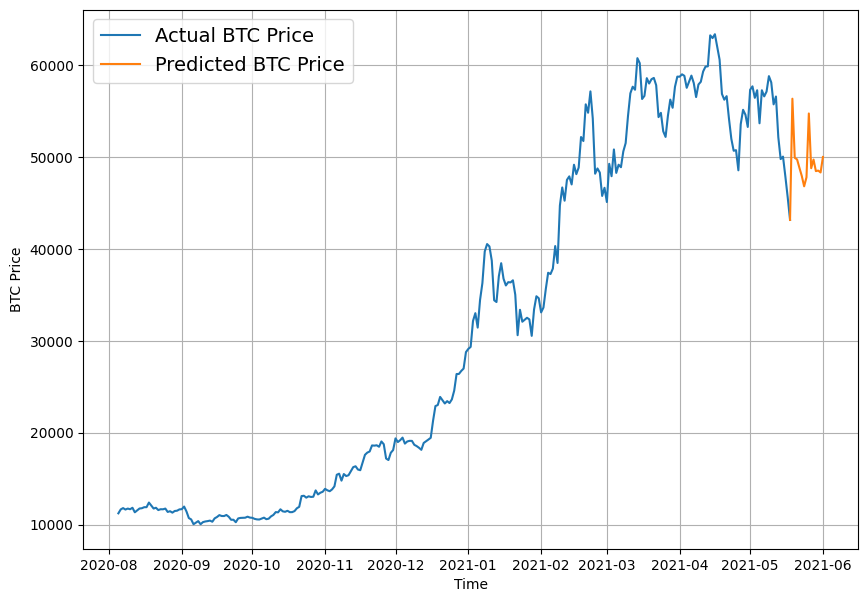

In [ ]:
# Plot future price predictions of Bitcoin
plt.figure(figsize=(10, 7))
plot_time_series(bitcoin_prices.index, btc_price, start=2500, format="-", label="Actual BTC Price")
plot_time_series(next_time_steps, future_forecast, format="-", label="Predicted BTC Price")

## Model 10: Why Forecasting is BS (The Turkey Problem 🦃)

When creating any kind of forecast, it’s crucial to keep the **turkey problem** in mind.

The **turkey problem** is an analogy that illustrates how your historical data may fail to capture a future event that could be catastrophic and lead to significant consequences.

The story goes that a turkey lives a great life for 1000 days, being well-fed and taken care of by its owners. But on the evening before Thanksgiving, everything changes.

Based on the turkey's observational data, it has no reason to believe things won’t continue as they always have. However, on day 1001, after 1000 good days, the turkey’s life takes a dramatic turn for the worse.

![Turkey problem illustrated: A turkey enjoys 1000 good days until the eve of Thanksgiving.](https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/10-the-turkey-problem.png)
*The turkey problem: A turkey might enjoy 1000 good days with no signs of what happens on day 1001. Similarly, in forecasting, historical data may not indicate a drastic future event. Graph image adapted from page 41 of [The Black Swan](https://en.wikipedia.org/wiki/The_Black_Swan:_The_Impact_of_the_Highly_Improbable) by Nassim Taleb.*

### How Does This Relate to Bitcoin Price Prediction?

You could have all the historical Bitcoin data and build a model that predicts it accurately—until one day, for an unknown and unpredictable reason, the price of Bitcoin plummets 100x in a single day.

This scenario may be unlikely, but its impact would be enormous.

Think about your own life. How many significant events have occurred seemingly out of nowhere? For example, you could visit a café for 10 years and unexpectedly meet someone who changes your life one day.

The same applies to predicting Bitcoin prices. You could make steady profits for 10 years, only to lose it all in a single day. It’s not how many times you get paid that matters, but how much you get paid.

> 📖 **Resource:** To learn more about the turkey problem, check out the following:
* [Explaining the XIV trade and why forecasting is BS](https://youtu.be/hRwimmE2wEk) by Nassim Taleb
* [*The Black Swan*](https://en.wikipedia.org/wiki/The_Black_Swan:_The_Impact_of_the_Highly_Improbable) by Nassim Taleb, particularly Chapter 4, which explains and discusses the turkey problem.

### Simulating a "Turkey Problem" in Bitcoin Price Modeling

To see how the turkey problem impacts forecasting, we’ll simulate a highly unlikely event in Bitcoin’s historical data: the price dropping 100x in one day.

> 🔑 **Note:** A rare and unpredictable event, like Bitcoin’s price dropping 100x in a single day, is referred to as a [**Black Swan** event](https://en.wikipedia.org/wiki/Black_swan_theory). These events are unknown unknowns, meaning they are impossible to predict but often have a significant impact.


In [ ]:
# Let's introduce a Turkey problem to our BTC data (price BTC falls 100x in one day)
btc_price_turkey = btc_price.copy()
btc_price_turkey[-1] = btc_price_turkey[-1] / 100

In [ ]:
# Manufacture an extra price on the end (to showcase the Turkey problem)
btc_price_turkey[-10:]

[58788.2096789273,
 58102.1914262342,
 55715.5466512869,
 56573.5554719043,
 52147.8211869823,
 49764.1320815975,
 50032.6931367648,
 47885.6252547166,
 45604.6157536131,
 431.44471290860304]

Notice the last value is 100x lower than what it actually was (remember, this is not a real data point, its only to illustrate the effects of the turkey problem).

Now we've got Bitcoin prices including a turkey problem data point, let's get the timesteps.

In [ ]:
# Get the timesteps for the turkey problem
btc_timesteps_turkey = np.array(bitcoin_prices.index)
btc_timesteps_turkey[-10:]

array(['2021-05-09T00:00:00.000000000', '2021-05-10T00:00:00.000000000',
       '2021-05-11T00:00:00.000000000', '2021-05-12T00:00:00.000000000',
       '2021-05-13T00:00:00.000000000', '2021-05-14T00:00:00.000000000',
       '2021-05-15T00:00:00.000000000', '2021-05-16T00:00:00.000000000',
       '2021-05-17T00:00:00.000000000', '2021-05-18T00:00:00.000000000'],
      dtype='datetime64[ns]')

Beautiful! Let's see our artificially created turkey problem Bitcoin data.

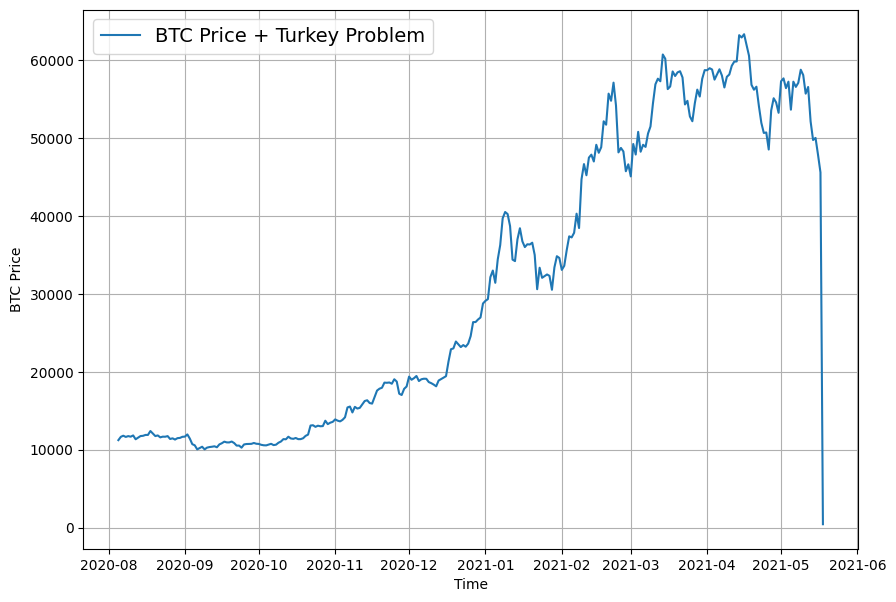

In [ ]:
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=btc_timesteps_turkey,
                 values=btc_price_turkey,
                 format="-",
                 label="BTC Price + Turkey Problem",
                 start=2500)

How do you think building a model on this data will go?

Remember, all we've changed is a single data point out of our entire dataset.

Before we build a model, let's create some windowed datasets with our turkey data.

In [ ]:
# Create train and test sets for turkey problem data
full_windows, full_labels = make_windows(np.array(btc_price_turkey), window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

X_train, X_test, y_train, y_test = make_train_test_splits(full_windows, full_labels)
len(X_train), len(X_test), len(y_train), len(y_test)

(2224, 556, 2224, 556)

### Building a turkey model (model to predict on turkey data)

With our updated data, we only changed 1 value.

To keep things comparable to previous models, we'll create a `turkey_model` which is a clone of `model_1` (same architecture, but different data).

That way, when we evaluate the `turkey_model` we can compare its results to `model_1_results` and see how much a single data point can influence a model's performance.


In [ ]:
# Clone model 1 architecture for turkey model and fit the turkey model on the turkey data
turkey_model = tf.keras.models.clone_model(model_1)
turkey_model._name = "Turkey_Model"
turkey_model.compile(loss="mae",
                     optimizer=tf.keras.optimizers.Adam())
turkey_model.fit(X_train, y_train,
                 epochs=100,
                 verbose=0,
                 validation_data=(X_test, y_test),
                 callbacks=[create_model_checkpoint(turkey_model.name)])


Epoch 1: val_loss improved from inf to 1070.13965, saving model to model_experiments/Turkey_Model.keras

Epoch 2: val_loss improved from 1070.13965 to 978.63379, saving model to model_experiments/Turkey_Model.keras

Epoch 3: val_loss improved from 978.63379 to 929.97284, saving model to model_experiments/Turkey_Model.keras

Epoch 4: val_loss improved from 929.97284 to 885.68713, saving model to model_experiments/Turkey_Model.keras

Epoch 5: val_loss did not improve from 885.68713

Epoch 6: val_loss improved from 885.68713 to 811.05707, saving model to model_experiments/Turkey_Model.keras

Epoch 7: val_loss did not improve from 811.05707

Epoch 8: val_loss did not improve from 811.05707

Epoch 9: val_loss did not improve from 811.05707

Epoch 10: val_loss improved from 811.05707 to 737.65186, saving model to model_experiments/Turkey_Model.keras

Epoch 11: val_loss did not improve from 737.65186

Epoch 12: val_loss improved from 737.65186 to 719.97412, saving model to model_experiments/

In [ ]:
# Evaluate turkey model on test data
turkey_model.evaluate(X_test, y_test)

18/18 [==============================] - 0s 2ms/step - loss: 740.3885


740.3885498046875

In [ ]:
# Load best model and evaluate on test data
turkey_model = tf.keras.models.load_model("model_experiments/Turkey_Model.keras")
turkey_model.evaluate(X_test, y_test)

18/18 [==============================] - 0s 2ms/step - loss: 642.6670


642.6669921875

Alright, now let's make some predictions with our model and evaluate them on the test data.

In [ ]:
# Make predictions with Turkey model
turkey_preds = make_preds(turkey_model, X_test)
turkey_preds[:10]

18/18 [==============================] - 0s 1ms/step


<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([8850.496, 8774.355, 9030.616, 8760.309, 8729.872, 8749.209,
       8671.014, 8520.688, 8455.214, 8526.154], dtype=float32)>

In [ ]:
# Evaluate turkey preds
turkey_results = evaluate_preds(y_true=y_test,
                                y_pred=turkey_preds)
turkey_results

{'mae': 17139.148,
 'mse': 615045570.0,
 'rmse': 23730.85,
 'mape': 121.49067,
 'mase': 1.0006896}

And with just one value change, our error metrics go through the roof.

To make sure, let's remind ourselves of how `model_1` went on unmodified Bitcoin data (no turkey problem).

In [ ]:
model_1_results

{'MAE': 561.84973,
 'MSE': 1150861.1,
 'RMSE': 1072.782,
 'MAPE': 2.5373905,
 'MASE': 0.6800274}

By changing just one value, the `turkey_model` MAE increases almost 30x over `model_1`.

Finally, we'll visualize the turkey predictions over the test turkey data.

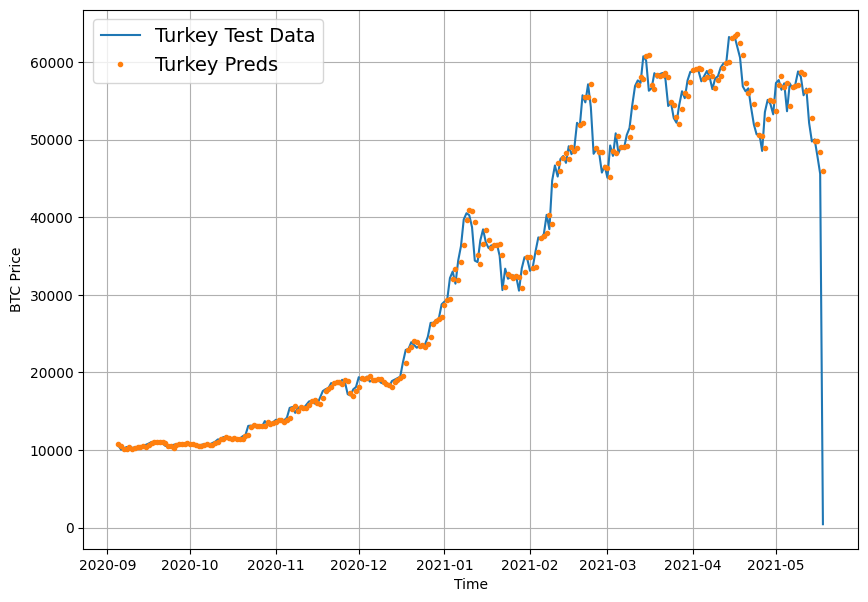

In [ ]:
plt.figure(figsize=(10, 7))
# plot_time_series(timesteps=btc_timesteps_turkey[:split_size], values=btc_price_turkey[:split_size], label="Train Data")
offset=300
plot_time_series(timesteps=btc_timesteps_turkey[-len(X_test):],
                 values=btc_price_turkey[-len(y_test):],
                 format="-",
                 label="Turkey Test Data", start=offset)
plot_time_series(timesteps=btc_timesteps_turkey[-len(X_test):],
                 values=turkey_preds,
                 label="Turkey Preds",
                 start=offset);

## Compare Models

We've trained several models and, if anything, we've learned how challenging it is for machine learning and deep learning models to accurately forecast the price of Bitcoin (or any open market value).

To emphasize this, let’s compare the results of all the modeling experiments we’ve conducted so far.


In [ ]:
# Compare different model results (w = window, h = horizon, e.g. w=7 means a window size of 7)
model_results = pd.DataFrame({"naive_model": naive_results,
                              "model_1_dense_w7_h1": model_1_results,
                              "model_2_dense_w30_h1": model_2_results,
                              "model_3_dense_w30_h7": model_3_results,
                              "model_4_CONV1D": model_4_results,
                              "model_5_LSTM": model_5_results,
                              "model_6_multivariate": model_6_results,
                              "model_8_NBEATs": model_7_results,
                              "model_9_ensemble": ensemble_results,
                              "model_10_turkey": turkey_results}).T
model_results.head(10)

,MAE,MSE,RMSE,MAPE,MASE,mae,mse,rmse,mape,mase
naive_model,567.980225,1147547.000,1071.236206,2.516525,0.692124,NaN,NaN,NaN,NaN,NaN
model_1_dense_w7_h1,561.849731,1150861.125,1072.781982,2.537390,0.680027,NaN,NaN,NaN,NaN,NaN
model_2_dense_w30_h1,627.218384,1323390.375,1150.387085,2.826738,0.720095,NaN,NaN,NaN,NaN,NaN
model_3_dense_w30_h7,1229.569458,5432461.000,2330.763916,5.547978,0.882976,NaN,NaN,NaN,NaN,NaN
model_4_CONV1D,NaN,NaN,NaN,NaN,NaN,574.784790,1.200913e+06,1095.861938,2.579100,0.684751
model_5_LSTM,NaN,NaN,NaN,NaN,NaN,599.359802,1.274344e+06,1128.868286,2.702127,0.698118
model_6_multivariate,NaN,NaN,NaN,NaN,NaN,565.059387,1.158709e+06,1076.433594,2.549412,0.679583
model_8_NBEATs,NaN,NaN,NaN,NaN,NaN,575.366150,1.183966e+06,1088.101929,2.602995,0.677768
model_9_ensemble,NaN,NaN,NaN,NaN,NaN,570.961365,1.145005e+06,1070.049194,2.581871,0.692242
model_10_turkey,NaN,NaN,NaN,NaN,NaN,17139.148438,6.150456e+08,23730.849609,121.490669,1.000690


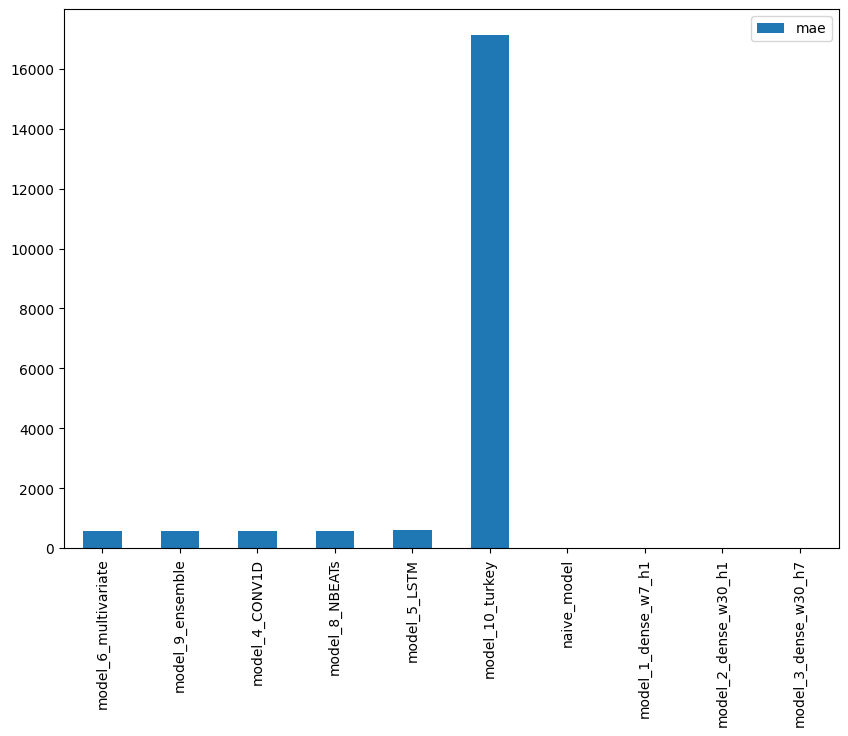

In [ ]:
# Sort model results by MAE and plot them
model_results[["mae"]].sort_values(by="mae").plot(figsize=(10, 7), kind="bar");